<h1> Project summary</h1>

This is a <b>comprehensive exploratory data analysis</b> mainly revolving around the <b>geographical exploration</b>, which is something the author has <b>never worked with before</b>.

<b>Particular focus is given to Europe</b>, especially Central Europe, since countries in this region are the <b>closest to the Czech Republic</b>, which is the country of origin of the author.

<h1> Project outline</h1>
    
    • State the initial hypotheses and assumptions, decide for an approach 
    • Make necessary imports, take first look at the dataset
    • Decide how to clean the dataset and engineer some of the missing values
    • Analyse the individual distribution of some of the important features
    • Research the relations of undernourishment, obesity and deaths
    • Perform an analysis of diet and deaths & obesity relations
        • Try splitting food into generally healthy & unhealthy
        • Give some additional focus to vegan lifestyle
    • Initiate geographical analysis
        • Start out with general world analysis
        • Pay special attention to Europe
        • Split the dataset into continents and compare these (add Czechia, Slovakia & Central Europe)
    • Correlation inspection

<h2>Hypotheses and notes</h2>

    • Some food products will lead to higher death percentages - alcohol, animal fats, sugars, stimulants
    • Animal fats and sugars will also lead to higher obesity percentage
    • On the contrary, food such as fish, fruits or vegetables will be correlated with lower death rates
    • Since obesity is a risk factor of covid, obesity & deaths will be positively correlated
    • Undernourished percentage and death rate will also be positively correlated since there are higher percentages of undernourishment in developing countries with worse health care

<h2> Necessary imports, first look at the dataset</h2>

In [199]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import geopandas as gpd
from shapely.geometry import Polygon

pd.set_option("max_columns", 40)
sb.set_style("whitegrid", {"grid.color": ".78"})
sb.set(palette="deep")
cmap = sb.diverging_palette(240, 25, as_cmap=True)

In [200]:
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [201]:
df = pd.read_csv("Food_supply_kcal_Data.csv")

In [202]:
# There is only one unique value in the unit column, therefore it is irrelevant
# This analysis revolves around confirmed cases and the percentage of deaths, therefore
# the recovered and active columns can be dropped
df.drop(columns=["Unit (all except Population)", "Recovered", "Active"], inplace=True)

# We had intended to build this research around the general diet trends and their relationship to covid death probability
    # The column "Deaths" present in the dataset consists of the percentage of all people in the country
    # this metric is strongly influenced by the rate of spread (number of people in the country, tourism, regulations etc.)
    # Column consisting of the percentage of deaths from confirmed cases would be way more valuable for our purposes
        # This will also be our target variable when we get to model building
df["Deaths"] = df["Deaths"]/df["Confirmed"]
    
# Based on the given direction, we could have dropped the columns "Confirmed", "Deaths" and "Population"
df.drop(columns=["Confirmed", "Population"], inplace=True)

In [203]:
df.head()

Country  Alcoholic Beverages  Animal Products  Animal fats  \
0          Afghanistan               0.0000           4.7774       0.8504   
1              Albania               0.9120          16.0930       1.0591   
2              Algeria               0.0896           6.0326       0.1941   
3               Angola               1.9388           4.6927       0.2644   
4  Antigua and Barbuda               2.3041          15.3672       1.5429   

   Aquatic Products, Other  Cereals - Excluding Beer    Eggs  Fish, Seafood  \
0                      0.0                   37.1186  0.1501         0.0000   
1                      0.0                   16.2107  0.8091         0.1471   
2                      0.0                   25.0112  0.4181         0.1195   
3                      0.0                   18.3521  0.0441         0.8372   
4                      0.0                   13.7215  0.2057         1.7280   

   Fruits - Excluding Wine    Meat  Milk - Excluding Butter  Miscellaneous  \
0                   1.4757  1.2006                   2.4512         0.0250   
1                   3.8982  3.8688                   9.9441         0.0588   
2                   3.1805  1.2543                   3.9869         0.1045   
3                   2.3133  2.9302                   0.5067         0.0661   
4                   3.6824  7.0356                   4.6904         0.3086   

   Offals  Oilcrops  Pulses  Spices  Starchy Roots  Stimulants  Sugar Crops  \
0  0.1251    0.1751  0.5003  0.1001         0.3252      0.0750          0.0   
1  0.2648    1.0886  0.8091  0.0000         1.2651      0.2501          0.0   
2  0.0597    0.2688  1.0900  0.1195         1.9262      0.1493          0.0   
3  0.1102    1.0795  1.4981  0.0000        12.6239      0.0441          0.0   
4  0.1646    0.5966  0.4526  0.3497         0.8434      0.4937          0.0   

   Sugar & Sweeteners  Treenuts  Vegetal Products  Vegetable Oils  Vegetables  \
0              2.2261    0.1251           45.2476          2.3012      0.7504   
1              3.4422    0.3972           33.9070          2.8244      2.7508   
2              3.9869    0.2240           43.9749          5.7638      2.0457   
3              2.7539    0.0000           45.3184          4.2741      0.3525   
4              5.8218    0.0823           34.6225          4.6904      1.2960   

   Obesity Undernourished    Deaths  
0      4.5           29.8  0.043521  
1     22.3            6.2  0.017171  
2     26.6            3.9  0.026779  
3      6.8             25  0.023677  
4     19.1            NaN  0.024306

In [204]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Country                   170 non-null    object 
 1   Alcoholic Beverages       170 non-null    float64
 2   Animal Products           170 non-null    float64
 3   Animal fats               170 non-null    float64
 4   Aquatic Products, Other   170 non-null    float64
 5   Cereals - Excluding Beer  170 non-null    float64
 6   Eggs                      170 non-null    float64
 7   Fish, Seafood             170 non-null    float64
 8   Fruits - Excluding Wine   170 non-null    float64
 9   Meat                      170 non-null    float64
 10  Milk - Excluding Butter   170 non-null    float64
 11  Miscellaneous             170 non-null    float64
 12  Offals                    170 non-null    float64
 13  Oilcrops                  170 non-null    float64
 14  Pulses    

In [205]:
# In order to transform the undernourished column to float, "<2.5" entries had to be replaced by 2.5
df["Undernourished"].replace({"<2.5": 2.5}, inplace=True)
df["Undernourished"] = df["Undernourished"].astype(float)

In [206]:
# There are 14 rows with some NaN entry in the dataset
# All NaNs present are located either in Obesity, Undernoursihed or Deaths dataset

df[df.isnull().any(1)]

Country  Alcoholic Beverages  Animal Products  Animal fats  \
4      Antigua and Barbuda               2.3041          15.3672       1.5429   
10                 Bahamas               2.9145          14.7930       1.4205   
52        French Polynesia               1.4879          15.0676       1.8129   
59                 Grenada               1.9979          12.2581       0.7284   
80                Kiribati               0.1145           5.9555       0.2291   
81            Korea, North               1.4282           3.1273       0.0000   
105                Myanmar               0.1296          10.8663       0.8145   
109          New Caledonia               1.9087          13.3430       1.4361   
124    Republic of Moldova               2.0672          12.2990       1.7958   
128  Saint Kitts and Nevis               1.6696          14.2715       1.6498   
129            Saint Lucia               2.5564          14.6429       1.0526   
147                Taiwan*               1.2767          10.9525       1.0415   
148             Tajikistan               0.1427           5.1831       0.0000   
155           Turkmenistan               0.2263          13.1267       1.7409   

     Aquatic Products, Other  Cereals - Excluding Beer    Eggs  Fish, Seafood  \
4                        0.0                   13.7215  0.2057         1.7280   
10                       0.0                   10.7274  0.6613         1.2491   
52                       0.0                   15.8885  0.4960         1.6419   
59                       0.0                   13.7565  0.7284         1.1446   
80                       0.0                   16.9993  0.1309         2.6014   
81                       0.0                   29.9926  0.4432         0.4186   
105                      0.0                   23.4358  0.3887         2.0548   
109                      0.0                   15.9607  0.6362         0.8544   
124                      0.0                   21.3823  0.6264         0.4803   
128                      0.0                   13.3969  0.3180         0.9541   
129                      0.0                   15.3571  0.2444         1.2218   
147                      0.0                   15.4208  0.9071         0.7559   
148                      0.0                   27.4132  0.2140         0.0238   
155                      0.0                   27.4025  0.4701         0.1045   

     Fruits - Excluding Wine    Meat  Milk - Excluding Butter  Miscellaneous  \
4                     3.6824  7.0356                   4.6904         0.3086   
10                    4.4575  8.1803                   2.9880         1.0776   
52                    1.0433  8.1409                   2.7364         1.1459   
59                    3.5588  5.7648                   3.8085         0.3538   
80                    1.8815  2.6832                   0.2781         0.1145   
81                    1.6991  2.0438                   0.1477         0.0246   
105                   1.3514  6.3680                   1.1107         0.0926   
109                   1.6906  6.5261                   3.7448         1.1089   
124                   1.1485  3.6542                   5.5753         0.1670   
128                   2.2262  7.5929                   3.5778         0.5367   
129                   2.0113  8.9286                   2.9323         0.4323   
147                   2.0830  6.9881                   1.1423         0.0840   
148                   1.5216  2.3776                   2.3776         0.0951   
155                   1.3231  6.4415                   4.3350         0.0870   

     Offals  Oilcrops  Pulses  Spices  Starchy Roots  Stimulants  Sugar Crops  \
4    0.1646    0.5966  0.4526  0.3497         0.8434      0.4937       0.0000   
10   0.2694    1.0287  0.1225  0.2204         0.7103      0.4164       0.0000   
52   0.2223    2.4457  0.3250  0.0171         1.9155      0.6670       0.1368   
59   0.0832    1.1863  1.3111  0.6452         1.1446      0.31

In [207]:
# A decision has been made to fill these values manually based on information from the internet
    # This strongly reduces the versatility of this code, however, it may have a significant impact
    # on the quality of the analysis and it's predictions
# The data present in these fillings may not be very precise or accurate, however
# we have decided to assume it is correct

df.loc[4, "Undernourished"] = 26.7
df.loc[10, "Undernourished"] = 10
df.loc[52, "Obesity"] = 40.9
df.loc[52, "Deaths"] = 0.0075
df.loc[59, "Undernourished"] = 25.5
df.loc[80, "Deaths"] = 0
df.loc[81, "Deaths"] = 0.01
df.loc[105, "Deaths"] = 0.0289
df.loc[109, "Obesity"] = 31.5
df.loc[109, "Deaths"] = 0
df.loc[124, "Undernourished"] = 8.5
df.loc[128, "Undernourished"] = 10.2
df.loc[129, "Undernourished"] = 5.5
df.loc[147, "Obesity"] = 22.8
df.loc[148, "Undernourished"] = 33.2
df.loc[155, "Deaths"] = 0

In [208]:
# Note: 
    # "0" in the "Deaths" column may signalize that this country does not publicly share
    # Covid-19 data or does not test it's citizens (or the samplesize of positive cases is just too small)

In [209]:
# Check the numeric variables, check for outliers, check mean and median, max and min values
pd.concat([df.describe().T, df.median().rename("median")], axis=1).T

<ipython-input-209-0b66c3a2525c>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pd.concat([df.describe().T, df.median().rename("median")], axis=1).T


Alcoholic Beverages  Animal Products  Animal fats  \
count            170.000000       170.000000   170.000000   
mean               1.325197         9.294553     1.267419   
std                1.062362         4.754174     1.283723   
min                0.000000         1.623700     0.000000   
25%                0.361300         5.082600     0.342850   
50%                1.244600         9.034100     0.877500   
75%                2.028050        13.174975     1.763175   
max                5.157400        22.291100     7.800700   
median             1.244600         9.034100     0.877500   

        Aquatic Products, Other  Cereals - Excluding Beer        Eggs  \
count                170.000000                170.000000  170.000000   
mean                   0.002786                 20.365358    0.428504   
std                    0.030879                  6.467936    0.304333   
min                    0.000000                  8.956500    0.018800   
25%                    0.000000                 15.306175    0.141000   
50%                    0.000000                 19.619950    0.403750   
75%                    0.000000                 24.841450    0.632950   
max                    0.400700                 37.526500    1.446100   
median                 0.000000                 19.619950    0.403750   

        Fish, Seafood  Fruits - Excluding Wine        Meat  \
count      170.000000               170.000000  170.000000   
mean         0.631501                 2.011975    3.896367   
std          0.579007                 1.416149    2.216693   
min          0.000000                 0.147100    0.298000   
25%          0.240150                 1.224525    2.080700   
50%          0.478300                 1.694850    3.687450   
75%          0.869675                 2.370700    5.278325   
max          4.418300                 8.854000   10.567400   
median       0.478300                 1.694850    3.687450   

        Milk - Excluding Butter  Miscellaneous      Offals    Oilcrops  \
count                170.000000     170.000000  170.000000  170.000000   
mean                   2.924466       0.159326    0.141220    1.103527   
std                    2.019384       0.216572    0.109816    1.590566   
min                    0.116900       0.000000    0.000000    0.017900   
25%                    1.107775       0.024700    0.078250    0.299250   
50%                    2.719800       0.088050    0.118250    0.636300   
75%                    4.319625       0.191725    0.176625    1.190200   
max                    9.944100       1.182200    0.801500   10.482200   
median                 2.719800       0.088050    0.118250    0.636300   

            Pulses      Spices  Starchy Roots  Stimulants  Sugar Crops  \
count   170.000000  170.000000     170.000000  170.000000   170.000000   
mean      1.108887    0.183202       3.083885    0.305375     0.017877   
std       1.204642    0.237672       3.892900    0.312164     0.071444   
min       0.000000    0.000000       0.293800    0.000000     0.000000   
25%       0.296675    0.036350       1.112325    0.077650     0.000000   
50%       0.708400    0.085900       1.544850    0.206750     0.000000   
75%       1.547150    0.227975       2.924450    0.420800     0.000000   
max       7.563800    1.220200      19.675900    2.009000     0.593000   
median    0.708400    0.085900       1.544850    0.206750     0.000000   

        Sugar & Sweeteners    Treenuts  Vegetal Products  Vegetable Oils  \
count           170.000000  170.000000        170.000000      170.000000   
mean              4.821161    0.261619         40.707045        4.872421   
std               2.140639    0.285631          4.754308        2.164249   
min               0.678600    0.000000         27.708900        0.932500   
25%               3.422175    0.046625         36.830725        3.126350   
50%               4.678350    0.174000         40.969700        4.660650   
75%               6.345800    0

In [210]:
# In this case, none of the outliers are actually eligible for dropping, since they preserve important information
# The only entry that could lead to drop based on data error would be value over 100, since all values are percentages
    # We can see above that there is no such entry
# This also means that the sum of all "diet" columns should add to +/- 100 (with some rounding errors)
sub_df = df.drop(columns=["Country", "Obesity", "Undernourished", "Deaths"])
print(sub_df.T.sum().agg(["min", "max"]))

min     99.9997
max    100.0003
dtype: float64


<h2>Variable Identification</h2>

In [211]:
# Target variable - "Deaths" - percentage of all Covid-19 cases that have resulted in death 
# Data types - text, numeric
# Variable category
    # Categorical:
        # Country
    # Continuous:
        # All others

<h2>Individual analysis of key variables</h2>

In [212]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Country                   170 non-null    object 
 1   Alcoholic Beverages       170 non-null    float64
 2   Animal Products           170 non-null    float64
 3   Animal fats               170 non-null    float64
 4   Aquatic Products, Other   170 non-null    float64
 5   Cereals - Excluding Beer  170 non-null    float64
 6   Eggs                      170 non-null    float64
 7   Fish, Seafood             170 non-null    float64
 8   Fruits - Excluding Wine   170 non-null    float64
 9   Meat                      170 non-null    float64
 10  Milk - Excluding Butter   170 non-null    float64
 11  Miscellaneous             170 non-null    float64
 12  Offals                    170 non-null    float64
 13  Oilcrops                  170 non-null    float64
 14  Pulses    

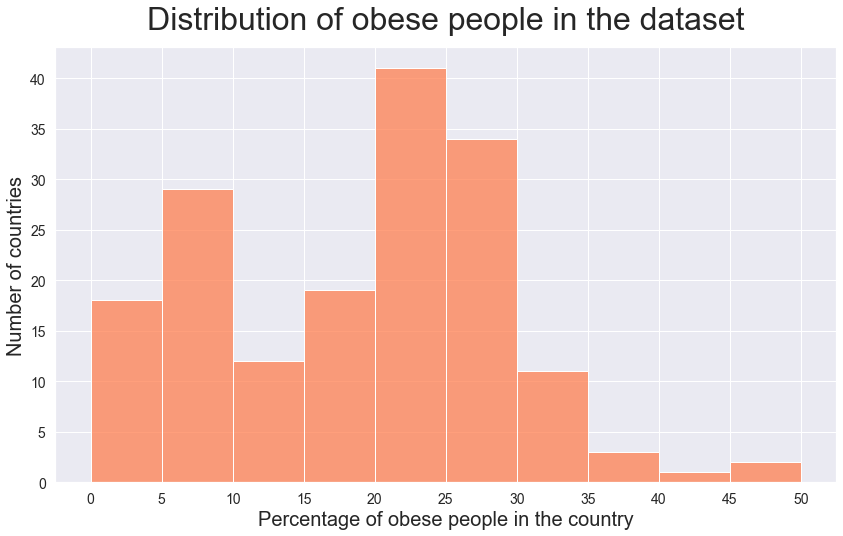

In [213]:
plt.figure(figsize=(14, 8))
sb.histplot(data=df["Obesity"], bins=range(0, 51, 5), color="coral")

plt.title("Distribution of obese people in the dataset", fontsize=32, pad=18)
plt.xlabel("Percentage of obese people in the country", fontsize=20)
plt.xticks(range(0, 51, 5), labels=range(0, 51, 5), fontsize=14)
plt.ylabel("Number of countries", fontsize=20)
plt.yticks(fontsize=14)

plt.show()

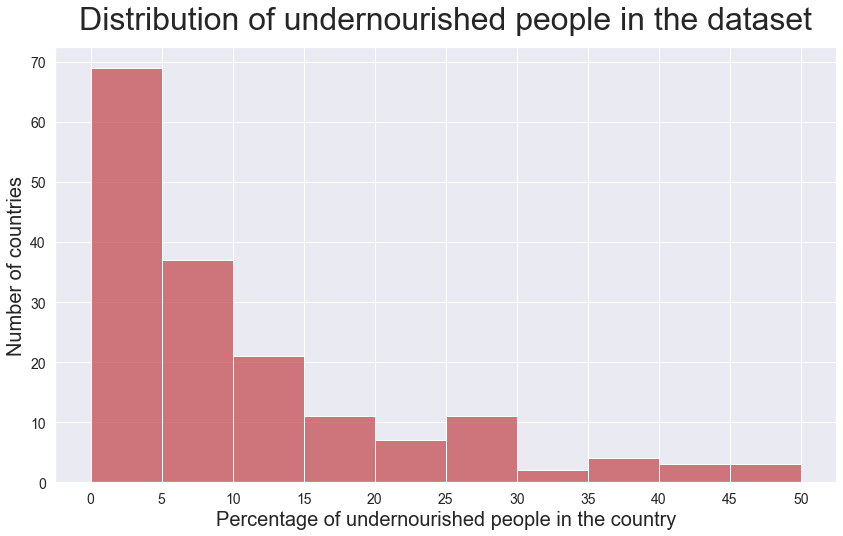

In [214]:
plt.figure(figsize=(14, 8))
sb.histplot(data=df["Undernourished"], bins=range(0, 51, 5), color="r")

plt.title("Distribution of undernourished people in the dataset", fontsize=32, pad=18)
plt.xlabel("Percentage of undernourished people in the country", fontsize=20)
plt.xticks(range(0, 51, 5), labels=range(0, 51, 5), fontsize=14)
plt.ylabel("Number of countries", fontsize=20)
plt.yticks(fontsize=14)

plt.show()

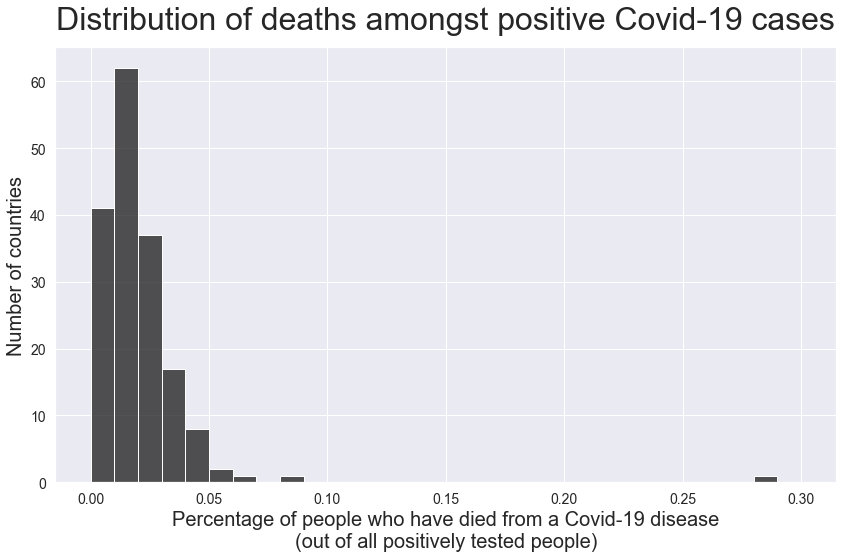

In [215]:
plt.figure(figsize=(14, 8))
sb.histplot(data=df["Deaths"], bins=np.arange(0, 0.31, 0.01), color="k")

plt.title("Distribution of deaths amongst positive Covid-19 cases", fontsize=32, pad=18)
plt.xlabel("Percentage of people who have died from a Covid-19 disease\n(out of all positively tested people)", fontsize=20)
plt.xticks(np.arange(0, 0.31, 0.05), fontsize=14)
plt.ylabel("Number of countries", fontsize=20)
plt.yticks(fontsize=14)

plt.show()

<h2>Key variables relationship</h2>

In [216]:
# Note: Although none of the outliers can be justifiably dropped in terms of the modeling and analysis,
# we have decided to dismiss some really massive outliers in order to preserve explanaibility of our charts
# and in order to avoid the need to scale the axes
    # To assess this, we have decided to temporarily drop entries which were off by more than 3 stds from the mean
    # in the respective columns

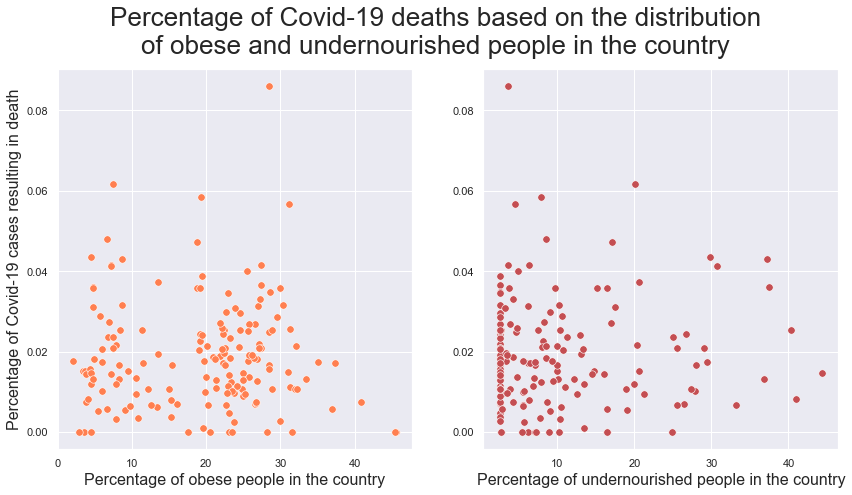

In [217]:
lst = ["Obesity", "Deaths", "Undernourished"]
sub_df = df.copy()

for var in lst:
    sub_df = sub_df[np.abs(sub_df[var]-sub_df[var].mean()) <= (3*sub_df[var].std())]

fig, axs = plt.subplots(1, 2, figsize=(14, 7))
fig.suptitle("Percentage of Covid-19 deaths based on the distribution\nof obese and undernourished people in the country",
            fontsize=26, y=1.003)

sb.scatterplot(data=sub_df, x="Obesity", y="Deaths", ax=axs[0], color="coral", s=55)

axs[0].set_xlabel("Percentage of obese people in the country", fontsize=16)
axs[0].set_ylabel("Percentage of Covid-19 cases resulting in death", fontsize=16)

sb.scatterplot(data=sub_df, x="Undernourished", y="Deaths", ax=axs[1], color="r", s=55)

axs[1].set_xlabel("Percentage of undernourished people in the country", fontsize=16)
axs[1].set_ylabel("")

plt.show()

<h2>Multivariate analysis</h2>

<h3>Healthy food</h3>

In [218]:
# We have educatedly decided to assume some types of food as "healthy at all times" although
# that is obviously not true in some extreme cases
    # Those types of food will be: Fish & Seafood, Fruits, Pulses, Treenuts and Vegetables

# Note: This approach may be a bit biased and misleading without additional information about the data
    # Apart from other reasons (such as personal bias of the author), this is due to the dataset
    # containing larger groups of food types, where some may be objectively healthy and some may be not
        # An example of this would be apples (healthy) but also apple products (may be unhealthy in some cases)

In [219]:
healthy = ["Fish, Seafood", "Fruits - Excluding Wine", "Pulses", "Treenuts", "Vegetables"]
labels = ["fish & seafood", "fruits", "pulses", "treenuts", "vegetables"]

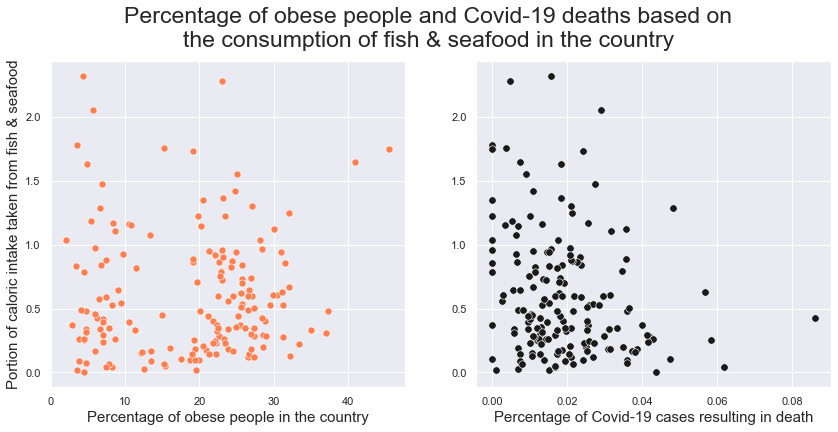

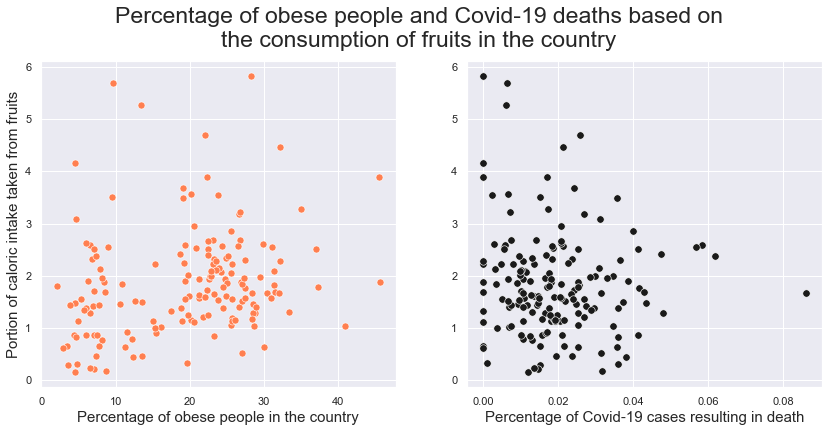

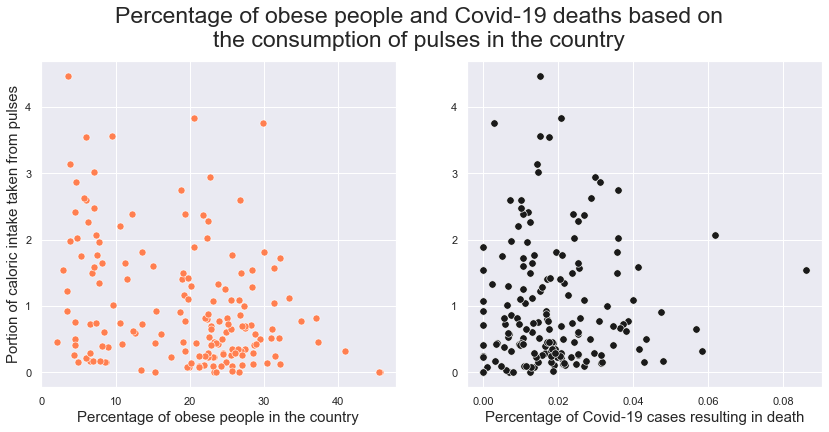

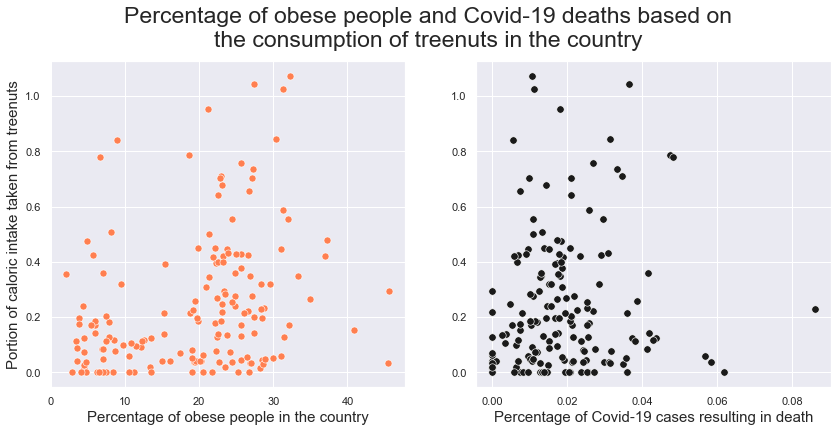

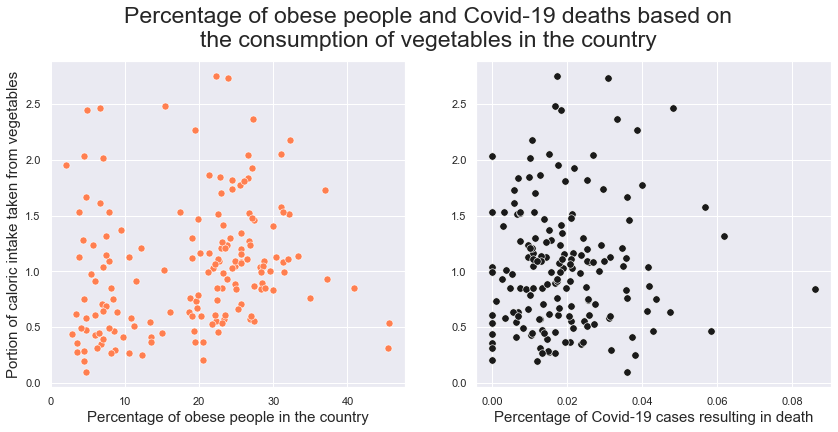

In [220]:
for food, label in zip(healthy, labels):
    lst = [food, "Obesity", "Deaths"]
    sub_df = df.copy()

    for var in lst:
        sub_df = sub_df[np.abs(sub_df[var]-sub_df[var].mean()) <= (3*sub_df[var].std())]
    
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f"Percentage of obese people and Covid-19 deaths based on\nthe consumption of {label} in the country",
                 fontsize=23, y=1.005)

    sb.scatterplot(data=sub_df, x="Obesity", y=food, ax=axs[0], color="coral", s=50)
    
    axs[0].set_xlabel("Percentage of obese people in the country", fontsize=15)
    axs[0].set_ylabel(f"Portion of caloric intake taken from {label}", fontsize=15)
    
    sb.scatterplot(data=sub_df, x="Deaths", y=food, ax=axs[1], color="k", s=55)
    
    axs[1].set_xlabel("Percentage of Covid-19 cases resulting in death", fontsize=15)
    axs[1].set_ylabel("")
    
    plt.show()

<h3>Unhealthy food</h3>

In [221]:
# We have educatedly decided to assume some types of food as "healthy at all times" although
# that is obviously not true in some extreme cases
    # Those types of food will be: Alcohol, Spices, Stimulants, Sugar (crops, products), Sweeteners, Vegetable oils
        # Some of these not necessarily unhealthy but often correlated with not very healthy cuisine or lifestyle

In [222]:
unhealthy = ["Alcoholic Beverages", "Spices", "Stimulants", "Sugar Crops", 
             "Sugar & Sweeteners", "Vegetable Oils"]
labels = ["alcohol", "spices", "stimulants", "sugar crops",
         "sugar & sweeteners", "vegetable oils"]

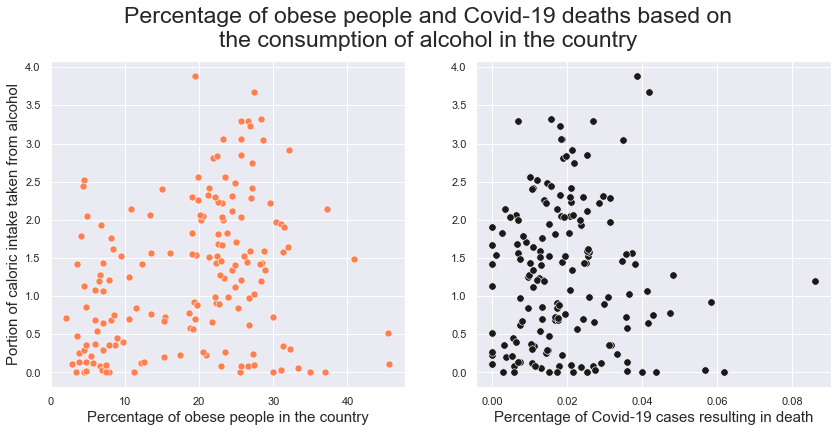

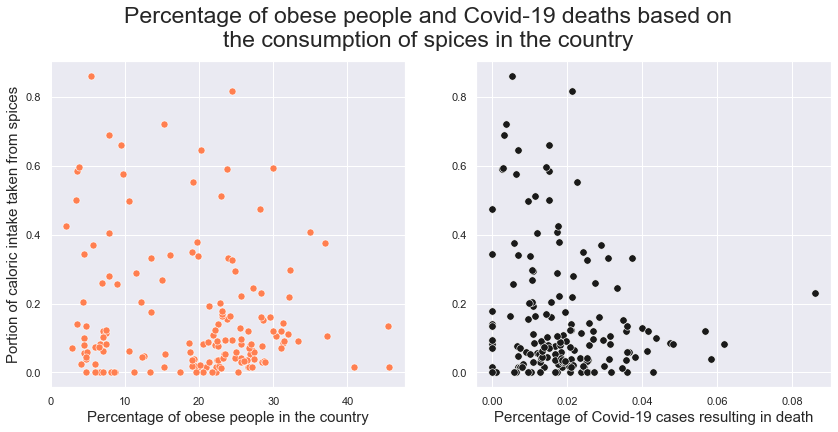

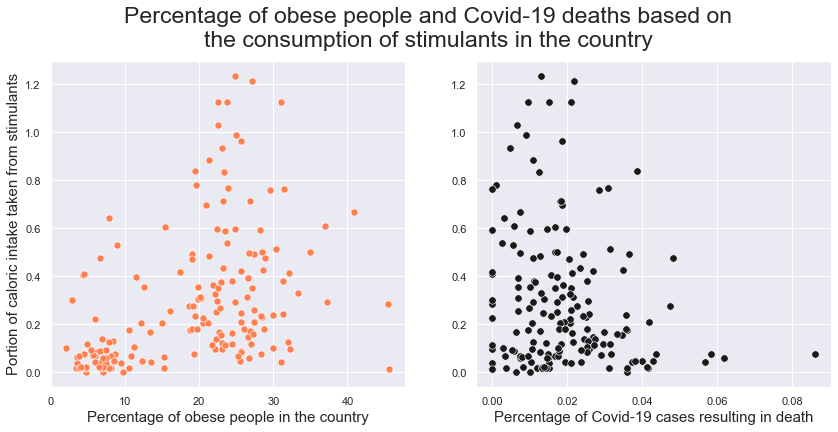

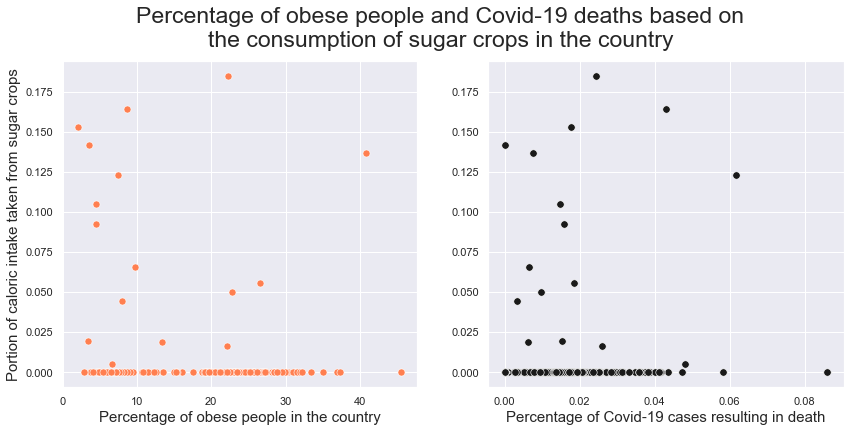

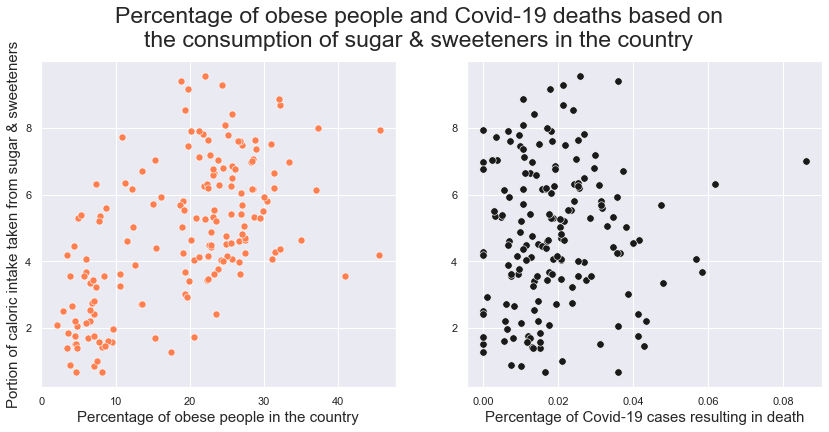

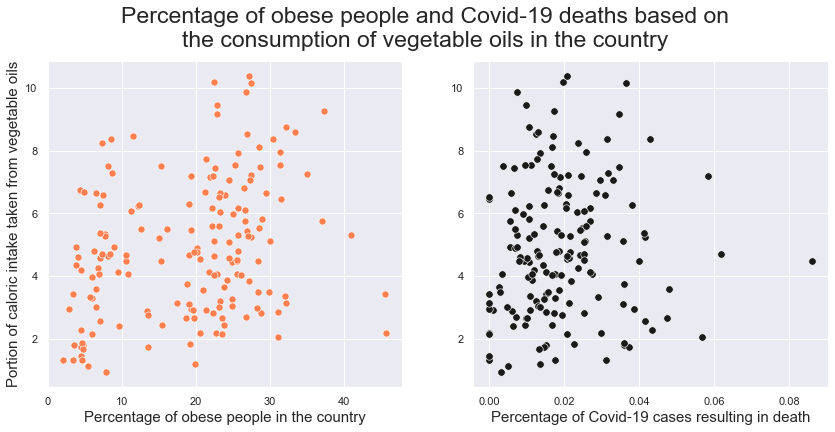

In [223]:
for food, label in zip(unhealthy, labels):
    lst = [food, "Obesity", "Deaths"]
    sub_df = df.copy()

    for var in lst:
        sub_df = sub_df[np.abs(sub_df[var]-sub_df[var].mean()) <= (3*sub_df[var].std())]
    
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f"Percentage of obese people and Covid-19 deaths based on\nthe consumption of {label} in the country",
                 fontsize=23, y=1.005)

    sb.scatterplot(data=sub_df, x="Obesity", y=food, ax=axs[0], color="coral", s=50)
    
    axs[0].set_xlabel("Percentage of obese people in the country", fontsize=15)
    axs[0].set_ylabel(f"Portion of caloric intake taken from {label}", fontsize=15)
    
    sb.scatterplot(data=sub_df, x="Deaths", y=food, ax=axs[1], color="k", s=55)
    
    axs[1].set_xlabel("Percentage of Covid-19 cases resulting in death", fontsize=15)
    axs[1].set_ylabel("")
    
    plt.show()

<h3>Vegan lifestyle</h3>

In [224]:
# In this chapter, we would like to analyse particularly some groups of food
# which are not being eaten by the vegan community to find out, whether 
# this approach is of any help in fights against obesity or covid

In [225]:
non_vegan = ["Animal Products", "Animal fats", "Aquatic Products, Other", "Eggs",
            "Fish, Seafood", "Meat", "Milk - Excluding Butter"]

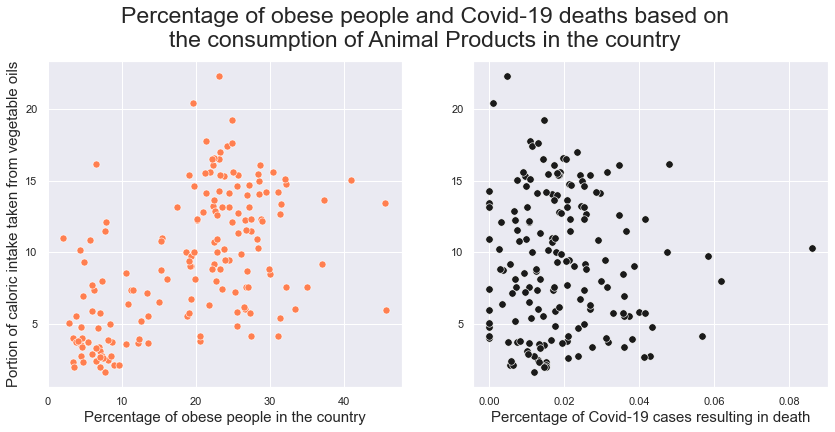

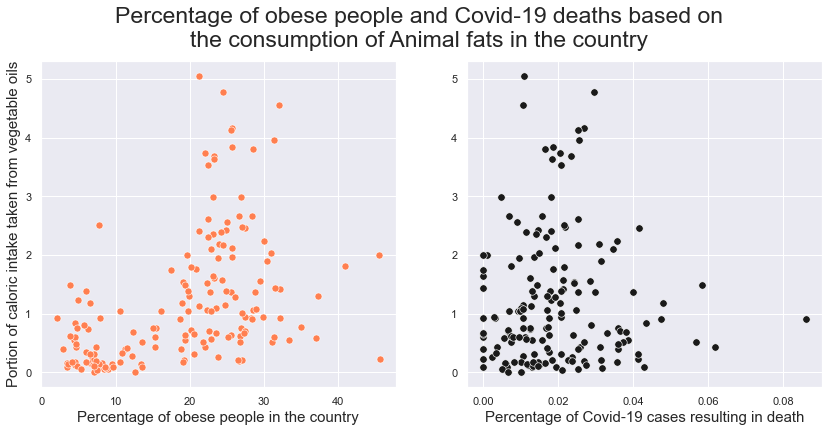

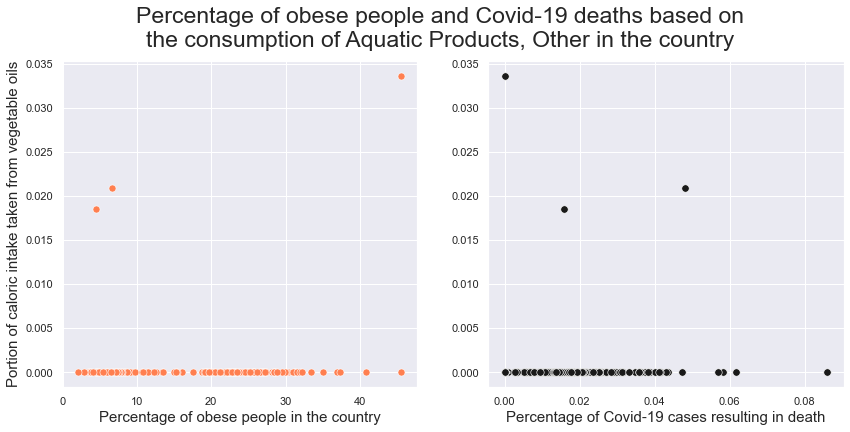

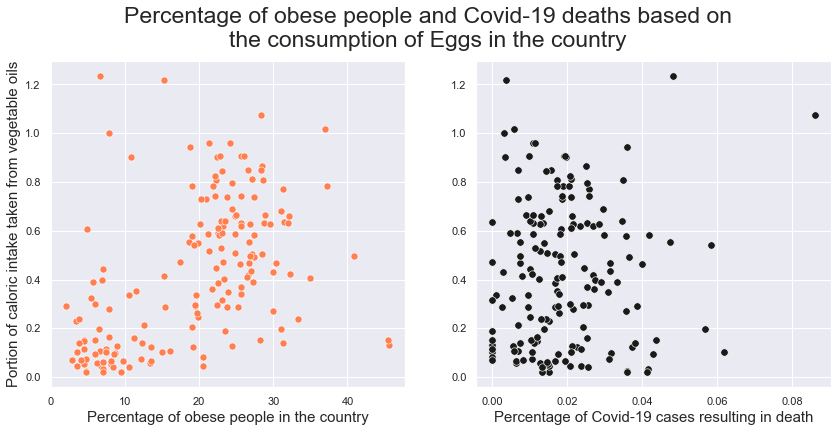

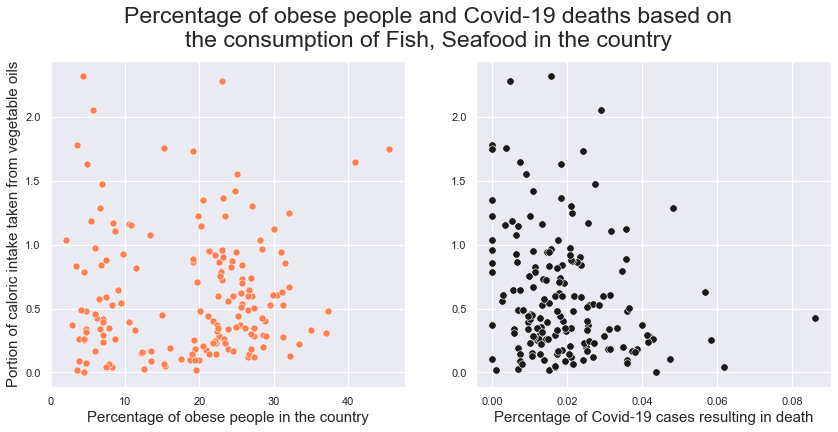

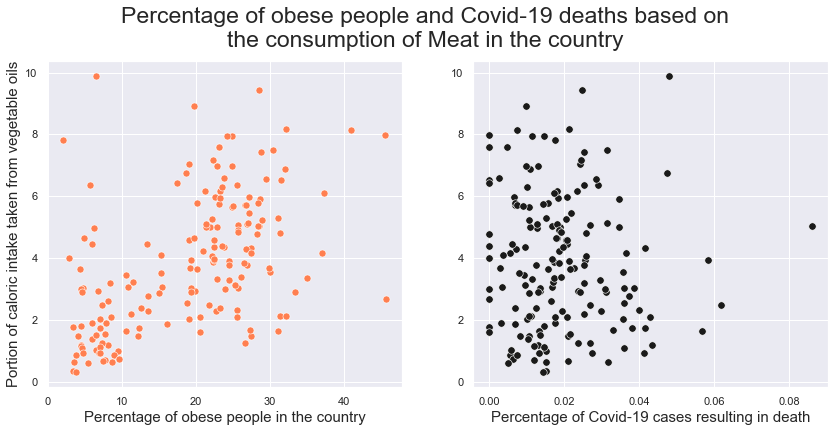

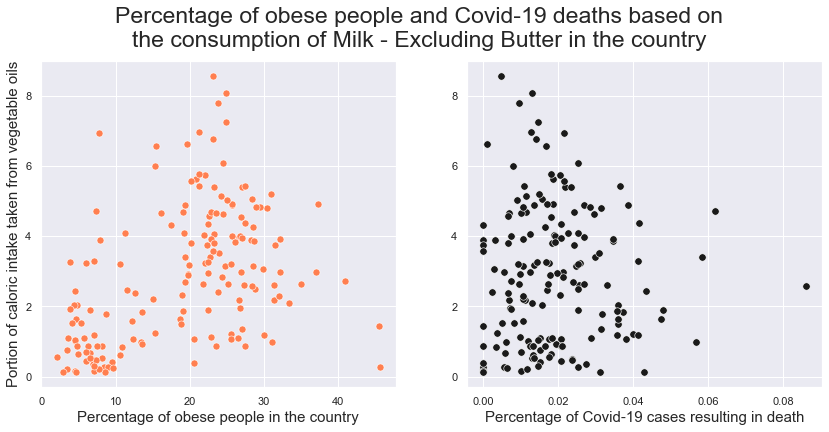

In [226]:
for food in non_vegan:
    lst = [food, "Obesity", "Deaths"]
    sub_df = df.copy()

    for var in lst:
        sub_df = sub_df[np.abs(sub_df[var]-sub_df[var].mean()) <= (3*sub_df[var].std())]   
    
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f"Percentage of obese people and Covid-19 deaths based on\nthe consumption of {food} in the country",
                 fontsize=23, y=1.005)

    sb.scatterplot(data=sub_df, x="Obesity", y=food, ax=axs[0], color="coral", s=50)
    
    axs[0].set_xlabel("Percentage of obese people in the country", fontsize=15)
    axs[0].set_ylabel(f"Portion of caloric intake taken from {label}", fontsize=15)
    
    sb.scatterplot(data=sub_df, x="Deaths", y=food, ax=axs[1], color="k", s=55)
    
    axs[1].set_xlabel("Percentage of Covid-19 cases resulting in death", fontsize=15)
    axs[1].set_ylabel("")
    
    plt.show()

<h2>Country based analysis</h2>

In [227]:
# Find some of the countries with most x least: 
    # obesity, undernourishment, deaths, alcohol consumption, fruits & vegetables consumption,
    # stimulants consumption, sugar & sweeteners consumption etc.
    
# Maybe try plotting some of the categories on map?

In [228]:
sub_df = df.copy().set_index("Country")

In [229]:
sub_df2 = pd.DataFrame(sub_df.loc[:, "Alcoholic Beverages"].sort_values(ascending=False))
sub_df2

Alcoholic Beverages
Country                                    
Luxembourg                           5.1574
Czechia                              4.8993
Estonia                              4.8390
Bosnia and Herzegovina               3.8856
Bulgaria                             3.6782
...                                     ...
United Arab Emirates                 0.0000
Kuwait                               0.0000
Pakistan                             0.0000
Sudan                                0.0000
Afghanistan                          0.0000

[170 rows x 1 columns]

In [230]:
sub_df2 = pd.DataFrame(sub_df.loc[:, "Fruits - Excluding Wine"].sort_values(ascending=False))
sub_df2

Fruits - Excluding Wine
Country                                       
Sao Tome and Principe                   8.8540
Rwanda                                  8.8056
Dominican Republic                      7.4210
Oman                                    6.8918
Uganda                                  6.6667
...                                        ...
Ethiopia                                0.2821
Zambia                                  0.2236
Togo                                    0.2058
Gambia                                  0.1771
Burkina Faso                            0.1471

[170 rows x 1 columns]

In [231]:
sub_df2 = pd.DataFrame(sub_df.loc[:, "Stimulants"].sort_values(ascending=False))
sub_df2

Stimulants
Country                 
Luxembourg        2.0090
Montenegro        1.2355
Croatia           1.2162
Malta             1.1270
Slovenia          1.1264
...                  ...
Mali              0.0171
Kiribati          0.0164
Ghana             0.0000
Chad              0.0000
Korea, North      0.0000

[170 rows x 1 columns]

In [232]:
sub_df2 = pd.DataFrame(sub_df.loc[:, "Sugar & Sweeteners"].sort_values(ascending=False))
sub_df2

Sugar & Sweeteners
Country                                
Colombia                         9.5492
Guatemala                        9.3995
Jamaica                          9.2690
Trinidad and Tobago              9.1537
New Zealand                      8.8706
...                                 ...
Sierra Leone                     1.0206
Nepal                            0.9069
Korea, North                     0.8619
Guinea-Bissau                    0.6881
Niger                            0.6786

[170 rows x 1 columns]

In [233]:
sub_df2 = pd.DataFrame(sub_df.loc[:, "Vegetables"].sort_values(ascending=False))
sub_df2

Vegetables
Country                    
Tajikistan           3.3524
Uzbekistan           3.2269
Armenia              3.2164
Guyana               3.1889
Albania              2.7508
...                     ...
Guinea-Bissau        0.2664
Zimbabwe             0.2532
Solomon Islands      0.2074
Burkina Faso         0.2022
Chad                 0.0957

[170 rows x 1 columns]

In [234]:
sub_df2 = pd.DataFrame(sub_df.loc[:, "Undernourished"].sort_values(ascending=False))
sub_df2

Undernourished
Country                                 
Central African Republic            59.6
Zimbabwe                            51.3
Haiti                               49.3
Korea, North                        47.8
Zambia                              46.7
...                                  ...
Denmark                              2.5
Romania                              2.5
Australia                            2.5
Czechia                              2.5
Austria                              2.5

[170 rows x 1 columns]

In [235]:
sub_df2 = pd.DataFrame(sub_df.loc[:, "Obesity"].sort_values(ascending=False))
sub_df2

Obesity
Country                          
Kiribati                     45.6
Samoa                        45.5
French Polynesia             40.9
United States of America     37.3
Kuwait                       37.0
...                           ...
Ethiopia                      3.6
Cambodia                      3.5
Bangladesh                    3.4
Timor-Leste                   2.9
Vietnam                       2.1

[170 rows x 1 columns]

In [236]:
# We have decided to drop rows with death occurences of 0
    # Those were mostly entered in the data because of small sample size or some data collection problem/error
    
sub_df2 = pd.DataFrame(sub_df[sub_df["Deaths"] > 0].loc[:, "Deaths"].sort_values(ascending=False))
sub_df2

Deaths
Country                                   
Yemen                             0.289140
Mexico                            0.086074
Sudan                             0.061787
Ecuador                           0.058355
Egypt                             0.056793
...                                    ...
Thailand                          0.003380
Maldives                          0.003242
United Arab Emirates              0.002826
Saint Vincent and the Grenadines  0.002496
Mongolia                          0.000989

[159 rows x 1 columns]

<h3>Geographical analysis</h3>

In [237]:
# Firstly, we will need to rename some of the countries 
# in order to get a match with geopandas database

# Since some of the smaller countries are not included in one or the other dataset,
# those will be dropped for the purpose of the geographical analysis

In [238]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world[(world.pop_est > 0) & (world.name != "Antarctica")]

In [239]:
# Excessive in sub_df
pd.DataFrame([x for x in list(sub_df.index) if x not in list(world.name)]).T

0         1                       2           3   \
0  Antigua and Barbuda  Barbados  Bosnia and Herzegovina  Cabo Verde   

                         4              5         6                   7   \
0  Central African Republic  Cote d'Ivoire  Dominica  Dominican Republic   

         8                 9        10                          11        12  \
0  Eswatini  French Polynesia  Grenada  Iran (Islamic Republic of)  Kiribati   

             13            14                                15        16  \
0  Korea, North  Korea, South  Lao People's Democratic Republic  Maldives   

      17         18               19                   20                  21  \
0  Malta  Mauritius  North Macedonia  Republic of Moldova  Russian Federation   

                      22           23                                24  \
0  Saint Kitts and Nevis  Saint Lucia  Saint Vincent and the Grenadines   

      25                     26               27       28  \
0  Samoa  Sao Tome and Principe  Solomon Islands  Taiwan*   

                            29                                  30  
0  United Republic of Tanzania  Venezuela (Bolivarian Republic of)

In [240]:
# Excessive in geopandas
pd.DataFrame(sorted([x for x in list(world.name) if x not in list(sub_df.index)])).T

0                 1       2        3                     4   \
0  Bhutan  Bosnia and Herz.  Brunei  Burundi  Central African Rep.   

              5                6               7           8        9   \
0  Côte d'Ivoire  Dem. Rep. Congo  Dominican Rep.  Eq. Guinea  Eritrea   

             10                      11         12    13      14    15     16  \
0  Falkland Is.  Fr. S. Antarctic Lands  Greenland  Iran  Kosovo  Laos  Libya   

          17       18         19           20         21                22  \
0  Macedonia  Moldova  N. Cyprus  North Korea  Palestine  Papua New Guinea   

            23     24      25        26           27       28          29  \
0  Puerto Rico  Qatar  Russia  S. Sudan  Solomon Is.  Somalia  Somaliland   

            30     31      32        33         34         35        36  
0  South Korea  Syria  Taiwan  Tanzania  Venezuela  W. Sahara  eSwatini

In [241]:
to_drop = ["Antigua and Barbuda", "Barbados", "Cabo Verde", "Dominica",
           "Eswatini", "French Polynesia", "Grenada", "Kiribati", "Maldives",
           "Malta", "Mauritius", "North Macedonia", "Saint Kitts and Nevis",
           "Saint Lucia", "Saint Vincent and the Grenadines", "Samoa", 
           "Sao Tome and Principe"]
sub_df = sub_df[~sub_df.index.isin(to_drop)]

sub_df.rename({"Bosnia and Herzegovina": "Bosnia and Herz.", 
               "Central African Republic": "Central African Rep.", 
               "Cote d'Ivoire": "Côte d'Ivoire", "Dominican Republic": "Dominican Rep.", 
               "Iran (Islamic Republic of)": "Iran", "Korea, North": "North Korea", 
               "Korea, South": "South Korea", "Lao People's Democratic Republic": "Laos", 
               "North Macedonia": "Macedonia", "Republic of Moldova": "Moldova", 
               "Russian Federation": "Russia", "Solomon Islands": "Solomon Is.", 
               "Taiwan*": "Taiwan", "United Republic of Tanzania": "Tanzania", 
               "Venezuela (Bolivarian Republic of)": "Venezuela"}, inplace=True)

missing = set(world.name) - set(sub_df.index)
l = len(sub_df.columns)
for country in missing:
    sub_df.loc[country] = [np.NaN]*l

world = world.merge(sub_df.reset_index().rename(columns={"Country": "name"}), on="name")

In [242]:
world["coords"] = world["geometry"].apply(lambda x: x.representative_point().coords[:])
world["coords"] = [coords[0] for coords in world["coords"]]

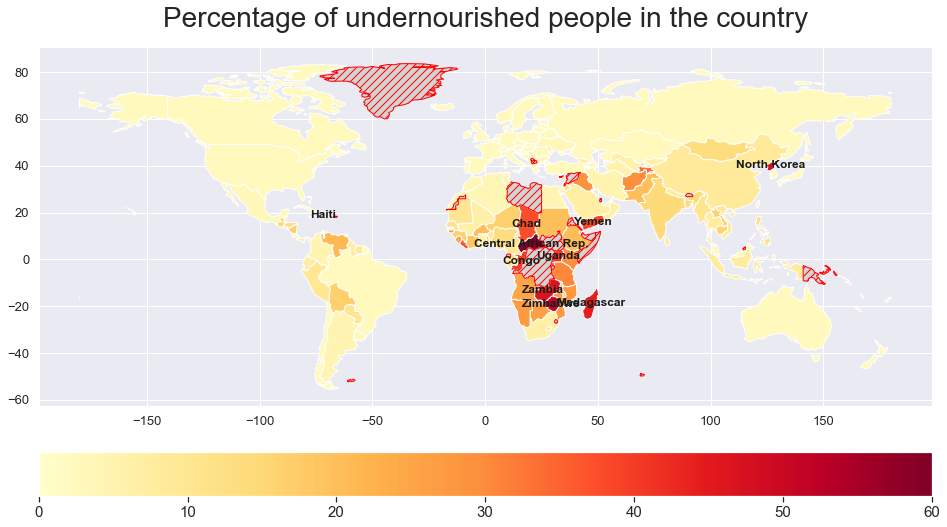

In [243]:
var = "Undernourished"
top = list(world.set_index("name")[var].sort_values(ascending=False)[:10].index)

ax = world.plot(column=var, vmin=0, vmax=60, figsize=(16, 14), cmap="YlOrRd", legend=True, 
                legend_kwds={"label": "", "orientation": "horizontal", "pad": 0.06}, 
                missing_kwds={"color": "lightgrey", "edgecolor": "red", "hatch": "///", "label": "Missing values"})
ax.figure.axes[0].tick_params(labelsize=13)
ax.figure.axes[1].tick_params(labelsize=15)

plt.title("Percentage of undernourished people in the country", fontsize=28, pad=20)

for country in top:
    row = world[world.name == country]
    ax.annotate(text=country, xy=row["coords"].values[0], 
                ha="center", va="center", color="k", weight="bold")

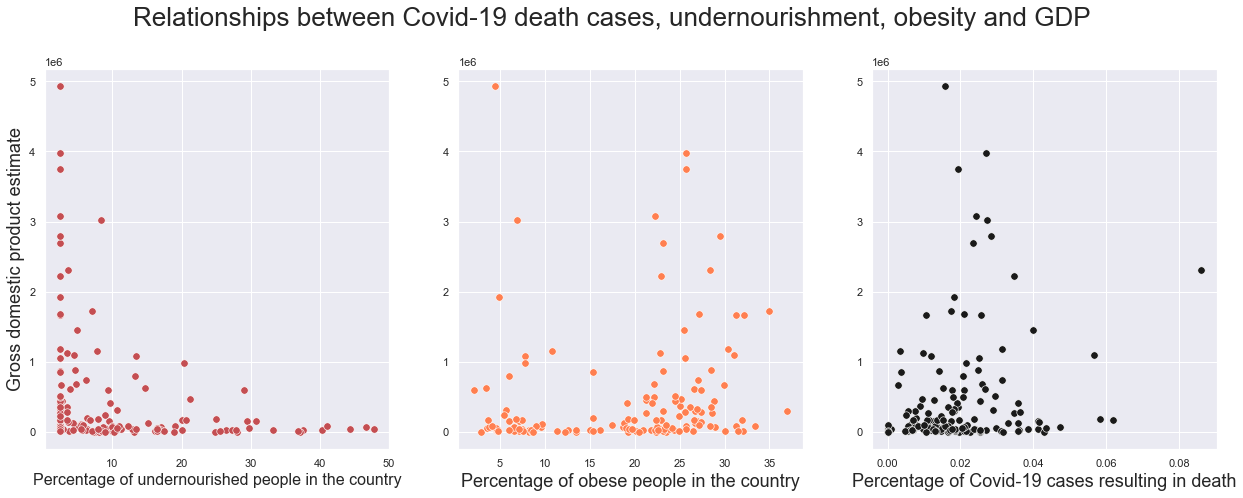

In [244]:
lst = ["Obesity", "Deaths", "Undernourished", "gdp_md_est"]
sub_df2 = world.copy()

for var in lst:
    sub_df2 = sub_df2[np.abs(sub_df2[var]-sub_df2[var].mean()) <= (3*sub_df2[var].std())]

fig, axs = plt.subplots(1, 3, figsize=(21, 7))
fig.suptitle("Relationships between Covid-19 death cases, undernourishment, obesity and GDP",
            fontsize=26, y=1.003)

sb.scatterplot(data=sub_df2, x="Undernourished", y="gdp_md_est", ax=axs[0], color="r", s=55)

axs[0].set_xlabel("Percentage of undernourished people in the country", fontsize=16)
axs[0].set_ylabel("Gross domestic product estimate", fontsize=18)

sb.scatterplot(data=sub_df2, x="Obesity", y="gdp_md_est", ax=axs[1], color="coral", s=55)

axs[1].set_xlabel("Percentage of obese people in the country", fontsize=18)
axs[1].set_ylabel("")

sb.scatterplot(data=sub_df2, x="Deaths", y="gdp_md_est", ax=axs[2], color="k", s=55)

axs[2].set_xlabel("Percentage of Covid-19 cases resulting in death", fontsize=18)
axs[2].set_ylabel("")

plt.show()

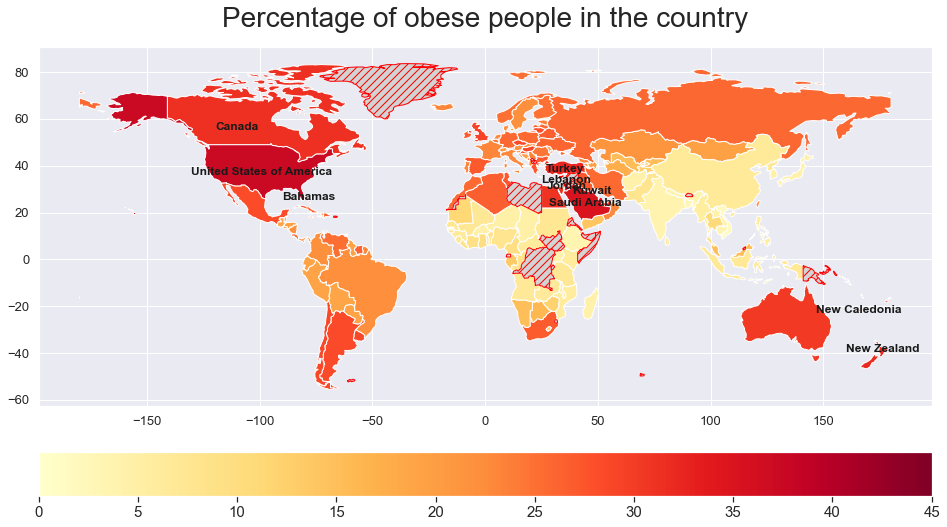

In [245]:
var = "Obesity"
top = list(world.set_index("name")[var].sort_values(ascending=False)[:10].index)

ax = world.plot(column=var, vmin=0, vmax=45, figsize=(16, 14), cmap="YlOrRd", legend=True, 
                legend_kwds={"label": "", "orientation": "horizontal", "pad": 0.06}, 
                missing_kwds={"color": "lightgrey", "edgecolor": "red", "hatch": "///", "label": "Missing values"})
ax.figure.axes[0].tick_params(labelsize=13)
ax.figure.axes[1].tick_params(labelsize=15)

plt.title("Percentage of obese people in the country", fontsize=28, pad=20)

for country in top:
    row = world[world.name == country]
    ax.annotate(text=country, xy=row["coords"].values[0], 
                ha="center", va="center", color="k", weight="bold")

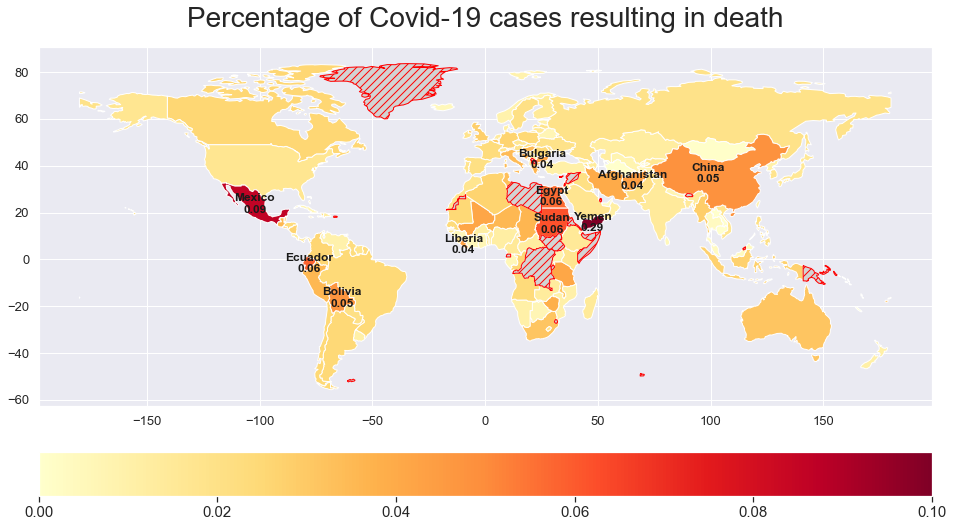

In [246]:
var = "Deaths"
top = list(world.set_index("name")[var].sort_values(ascending=False)[:10].index)

ax = world.plot(column=var, vmin=0, vmax=0.1, figsize=(16, 14), cmap="YlOrRd", legend=True, 
                legend_kwds={"label": "", "orientation": "horizontal", "pad": 0.06}, 
                missing_kwds={"color": "lightgrey", "edgecolor": "red", "hatch": "///", "label": "Missing values"})
ax.figure.axes[0].tick_params(labelsize=13)
ax.figure.axes[1].tick_params(labelsize=15)

plt.title("Percentage of Covid-19 cases resulting in death", fontsize=28, pad=20)

for country in top:
    row = world[world.name == country]
    ax.annotate(text=country+"\n"+str(row[var].values[0].round(2)), xy=row["coords"].values[0], 
                ha="center", va="center", color="k", weight="bold")

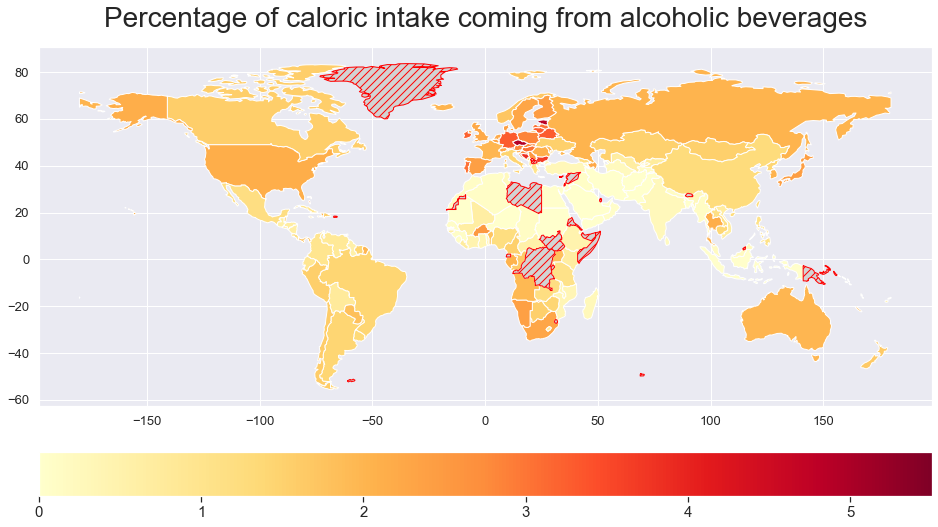

In [247]:
var = "Alcoholic Beverages"
ax = world.plot(column=var, vmin=0, vmax=5.5, figsize=(16, 14), cmap="YlOrRd", legend=True, 
                legend_kwds={"label": "", "orientation": "horizontal", "pad": 0.06}, 
                missing_kwds={"color": "lightgrey", "edgecolor": "red", "hatch": "///", "label": "Missing values"})
ax.figure.axes[0].tick_params(labelsize=13)
ax.figure.axes[1].tick_params(labelsize=15)

plt.title("Percentage of caloric intake coming from alcoholic beverages", fontsize=28, pad=20)

plt.show()

<h3>Analysis with respect to Europe</h3>

In [248]:
europe = world[world["continent"] == "Europe"]
europe = europe[(europe["name"] != "Iceland") & (europe["name"] != "Russia")]
polygon = Polygon([(-25,35), (40,35), (40,75),(-25,75)])
europe = gpd.clip(europe, polygon)

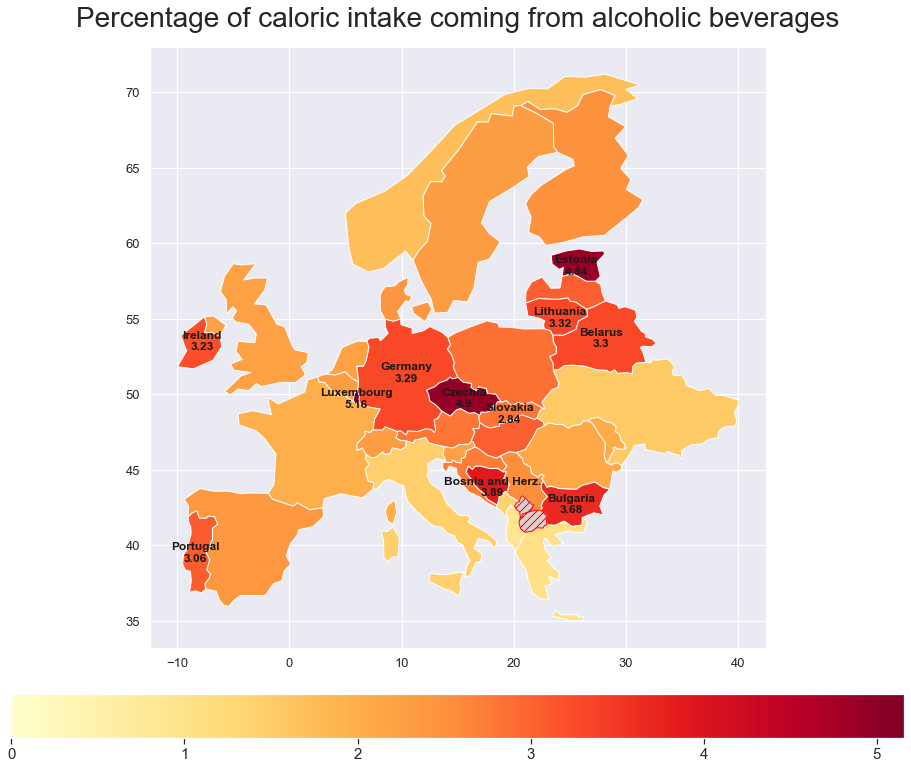

In [249]:
var = "Alcoholic Beverages"
top = set(list(europe.set_index("name")[var].sort_values(ascending=False)[:10].index) + ["Czechia", "Slovakia"])

ax = europe.plot(column=var, vmin=0, figsize=(16, 14), cmap="YlOrRd", legend=True, 
                 legend_kwds={"label": "", "orientation": "horizontal", "pad": 0.06}, 
                 missing_kwds={"color": "lightgrey", "edgecolor": "red", "hatch": "///", "label": "Missing values"})
ax.figure.axes[0].tick_params(labelsize=13)
ax.figure.axes[1].tick_params(labelsize=15)

plt.title("Percentage of caloric intake coming from alcoholic beverages", fontsize=28, pad=20)

for country in top:
    row = europe[europe.name == country]
    ax.annotate(text=country+"\n"+str(row[var].values[0].round(2)), xy=row["coords"].values[0], 
                ha="center", va="center", color="k", weight="bold")

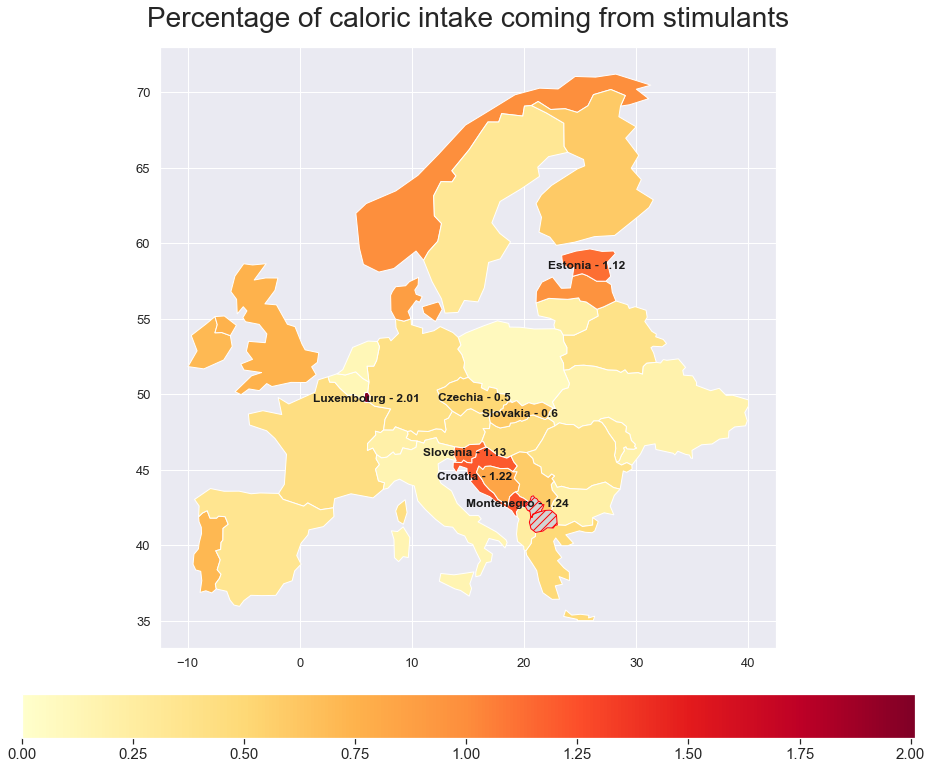

In [250]:
var = "Stimulants"
top = set(list(europe.set_index("name")[var].sort_values(ascending=False)[:5].index) + ["Czechia", "Slovakia"])

ax = europe.plot(column=var, vmin=0, figsize=(16, 14), cmap="YlOrRd", legend=True, 
                 legend_kwds={"label": "", "orientation": "horizontal", "pad": 0.06}, 
                 missing_kwds={"color": "lightgrey", "edgecolor": "red", "hatch": "///", "label": "Missing values"})
ax.figure.axes[0].tick_params(labelsize=13)
ax.figure.axes[1].tick_params(labelsize=15)

plt.title("Percentage of caloric intake coming from stimulants", fontsize=28, pad=20)

for country in top:
    row = europe[europe.name == country]
    ax.annotate(text=country+" - "+str(row[var].values[0].round(2)), xy=row["coords"].values[0], 
                ha="center", va="center", color="k", weight="bold")

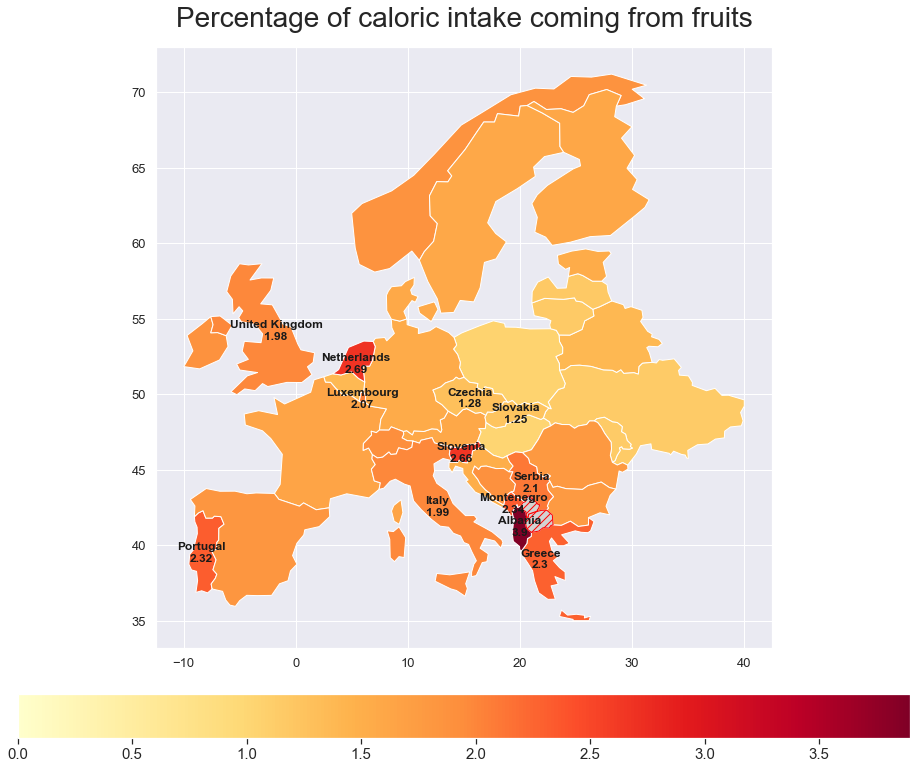

In [251]:
var = "Fruits - Excluding Wine"
top = set(list(europe.set_index("name")[var].sort_values(ascending=False)[:10].index) + ["Czechia", "Slovakia"])

ax = europe.plot(column=var, vmin=0, figsize=(16, 14), cmap="YlOrRd", legend=True, 
                 legend_kwds={"label": "", "orientation": "horizontal", "pad": 0.06}, 
                 missing_kwds={"color": "lightgrey", "edgecolor": "red", "hatch": "///", "label": "Missing values"})
ax.figure.axes[0].tick_params(labelsize=13)
ax.figure.axes[1].tick_params(labelsize=15)

plt.title("Percentage of caloric intake coming from fruits", fontsize=28, pad=20)

for country in top:
    row = europe[europe.name == country]
    ax.annotate(text=country+"\n"+str(row[var].values[0].round(2)), xy=row["coords"].values[0], 
                ha="center", va="center", color="k", weight="bold")

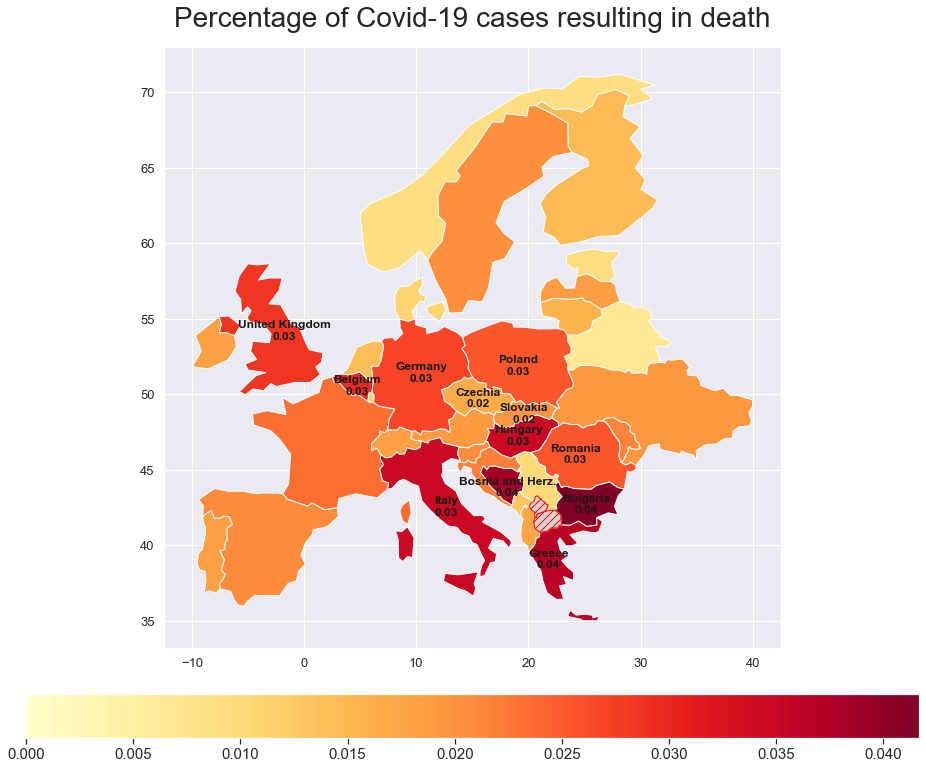

In [252]:
var = "Deaths"
top = set(list(europe.set_index("name")[var].sort_values(ascending=False)[:10].index) + ["Czechia", "Slovakia"])

ax = europe.plot(column=var, vmin=0, figsize=(16, 14), cmap="YlOrRd", legend=True, 
                 legend_kwds={"label": "", "orientation": "horizontal", "pad": 0.06}, 
                 missing_kwds={"color": "lightgrey", "edgecolor": "red", "hatch": "///", "label": "Missing values"})
ax.figure.axes[0].tick_params(labelsize=13)
ax.figure.axes[1].tick_params(labelsize=15)

plt.title("Percentage of Covid-19 cases resulting in death", fontsize=28, pad=20)

for country in top:
    row = europe[europe.name == country]
    ax.annotate(text=country+"\n"+str(row[var].values[0].round(2)), xy=row["coords"].values[0], 
                ha="center", va="center", color="k", weight="bold")

In [253]:
sub_df = world.set_index("name").drop(columns=["iso_a3", "geometry", "coords"])
sub_df_copy = sub_df.copy()

central_lst = ["Austria", "Croatia", "Czechia", "Germany", 
           "Hungary", "Poland", "Romania", "Slovakia", "Slovenia"]

CR = pd.DataFrame(sub_df.loc["Czechia"]).T
SR = pd.DataFrame(sub_df.loc["Slovakia"]).T
central = pd.DataFrame(sub_df[sub_df.index.isin(central_lst)].drop(columns=["continent"]).mean().rename("Central Europe")).T
europe = pd.DataFrame(sub_df[sub_df.index.isin(list(europe.name) + ["Russia", "Iceland"])].drop(columns=["continent"]).mean().rename("Europe")).T
africa = pd.DataFrame(sub_df[sub_df["continent"] == "Africa"].drop(columns=["continent"]).mean().rename("Africa")).T
asia = pd.DataFrame(sub_df[sub_df["continent"] == "Asia"].drop(columns=["continent"]).mean().rename("Asia")).T
north_america = pd.DataFrame(sub_df[sub_df["continent"] == "North America"].drop(columns=["continent"]).mean().rename("North America")).T
south_america = pd.DataFrame(sub_df[sub_df["continent"] == "South America"].drop(columns=["continent"]).mean().rename("South America")).T
oceania = pd.DataFrame(sub_df[sub_df["continent"] == "Oceania"].drop(columns=["continent"]).mean().rename("Oceania")).T
world_group = pd.DataFrame(sub_df.drop(columns=["continent"]).mean().rename("World")).T

sub_df = pd.concat([CR, SR, central, europe, 
                    africa, asia, north_america, 
                    south_america, oceania, world_group])

In [254]:
sub_df.rename(columns={"gdp_md_est": "Gross domestic product", 
                       "pop_est": "Population estimate"}, inplace=True)
sub_df = sub_df.drop(columns=["continent"]).astype(float).round(3)

animal = ["Animal Products", "Animal fats", "Eggs", 
          "Fish, Seafood", "Meat", "Milk - Excluding Butter"]
vegetal = ["Cereals - Excluding Beer", "Fruits - Excluding Wine",
          "Oilcrops", "Starchy Roots", "Treenuts", "Vegetal Products",
          "Vegetable Oils", "Vegetables"]
other = ["Miscellaneous", "Pulses", "Spices", "Stimulants", 
        "Sugar & Sweeteners"]
info = ["Gross domestic product", "Obesity", "Undernourished", "Deaths"]

In [255]:
sub_df[animal]

Animal Products  Animal fats   Eggs  Fish, Seafood   Meat  \
Czechia                  14.042        3.816  0.504          0.290  5.037   
Slovakia                 16.540        7.801  0.903          0.325  4.370   
Central Europe           14.855        4.293  0.655          0.375  5.063   
Europe                   14.815        2.864  0.684          0.651  5.303   
Africa                    4.253        0.302  0.116          0.424  1.872   
Asia                      8.305        0.844  0.473          0.634  3.595   
North America             9.298        1.380  0.520          0.457  3.998   
South America             9.914        0.855  0.552          0.388  5.106   
Oceania                  10.695        1.913  0.381          0.969  5.075   
World                     9.117        1.286  0.436          0.557  3.765   

                Milk - Excluding Butter  
Czechia                           4.274  
Slovakia                          2.961  
Central Europe                    4.347  
Europe                            5.158  
Africa                            1.393  
Asia                              2.598  
North America                     2.824  
South America                     2.883  
Oceania                           2.215  
World                             2.925

In [256]:
sub_df[vegetal]

Cereals - Excluding Beer  Fruits - Excluding Wine  Oilcrops  \
Czechia                           11.401                    1.282     0.244   
Slovakia                          10.672                    1.246     0.524   
Central Europe                    14.050                    1.527     0.407   
Europe                            14.872                    1.767     0.386   
Africa                            24.169                    1.898     1.360   
Asia                              24.700                    1.800     0.870   
North America                     18.416                    2.526     0.853   
South America                     19.137                    2.281     0.670   
Oceania                           15.510                    1.509     3.589   
World                             20.727                    1.921     0.973   

                Starchy Roots  Treenuts  Vegetal Products  Vegetable Oils  \
Czechia                 1.770     0.198            35.974           8.120   
Slovakia                1.697     0.271            33.460          10.202   
Central Europe          1.770     0.336            35.149           6.361   
Europe                  1.862     0.390            35.188           5.519   
Africa                  6.700     0.156            45.748           4.569   
Asia                    1.361     0.337            41.697           4.717   
North America           1.448     0.152            40.707           5.167   
South America           2.673     0.145            40.078           5.203   
Oceania                 5.543     0.277            39.304           4.612   
World                   3.189     0.264            40.884           4.952   

                Vegetables  
Czechia              0.900  
Slovakia             0.849  
Central Europe       1.219  
Europe               1.287  
Africa               0.754  
Asia                 1.451  
North America        0.811  
South America        0.981  
Oceania              0.815  
World                1.096

In [257]:
sub_df[other]

Miscellaneous  Pulses  Spices  Stimulants  Sugar & Sweeteners
Czechia                 0.107   0.290   0.076       0.504               6.166
Slovakia                0.072   0.235   0.090       0.596               4.171
Central Europe          0.057   0.234   0.122       0.569               5.515
Europe                  0.139   0.367   0.146       0.581               5.228
Africa                  0.077   1.936   0.156       0.083               3.056
Asia                    0.120   0.914   0.249       0.292               4.163
North America           0.250   1.811   0.138       0.213               7.534
South America           0.105   0.865   0.080       0.233               6.461
Oceania                 0.275   0.770   0.101       0.331               4.838
World                   0.132   1.140   0.169       0.295               4.683

In [258]:
sub_df[info]

Gross domestic product  Obesity  Undernourished  Deaths
Czechia                     350900.000   28.500           2.500   0.017
Slovakia                    168800.000   22.400           3.400   0.020
Central Europe              759832.222   25.200           2.600   0.023
Europe                      648330.179   24.603           2.941   0.020
Africa                      118143.049   10.415          22.032   0.022
Asia                       1179459.740   15.512          11.705   0.020
North America              1305840.944   25.037          10.612   0.025
South America               490545.523   23.133           8.358   0.027
Oceania                     201840.714   27.983           5.317   0.013
World                       670681.307   18.427          11.725   0.022

<h2>Correlation Analysis</h2>

In [259]:
grouped_by_continents = sub_df.copy()

<h3>Country based</h3>

In [260]:
sub_df = world.set_index("name").drop(columns=["iso_a3", "geometry", "coords", "continent"])
sub_df.rename(columns={"gdp_md_est": "Gross domestic product",
                       "pop_est": "Population estimate"}, inplace=True)
sub_df = sub_df.astype(float).round(3)

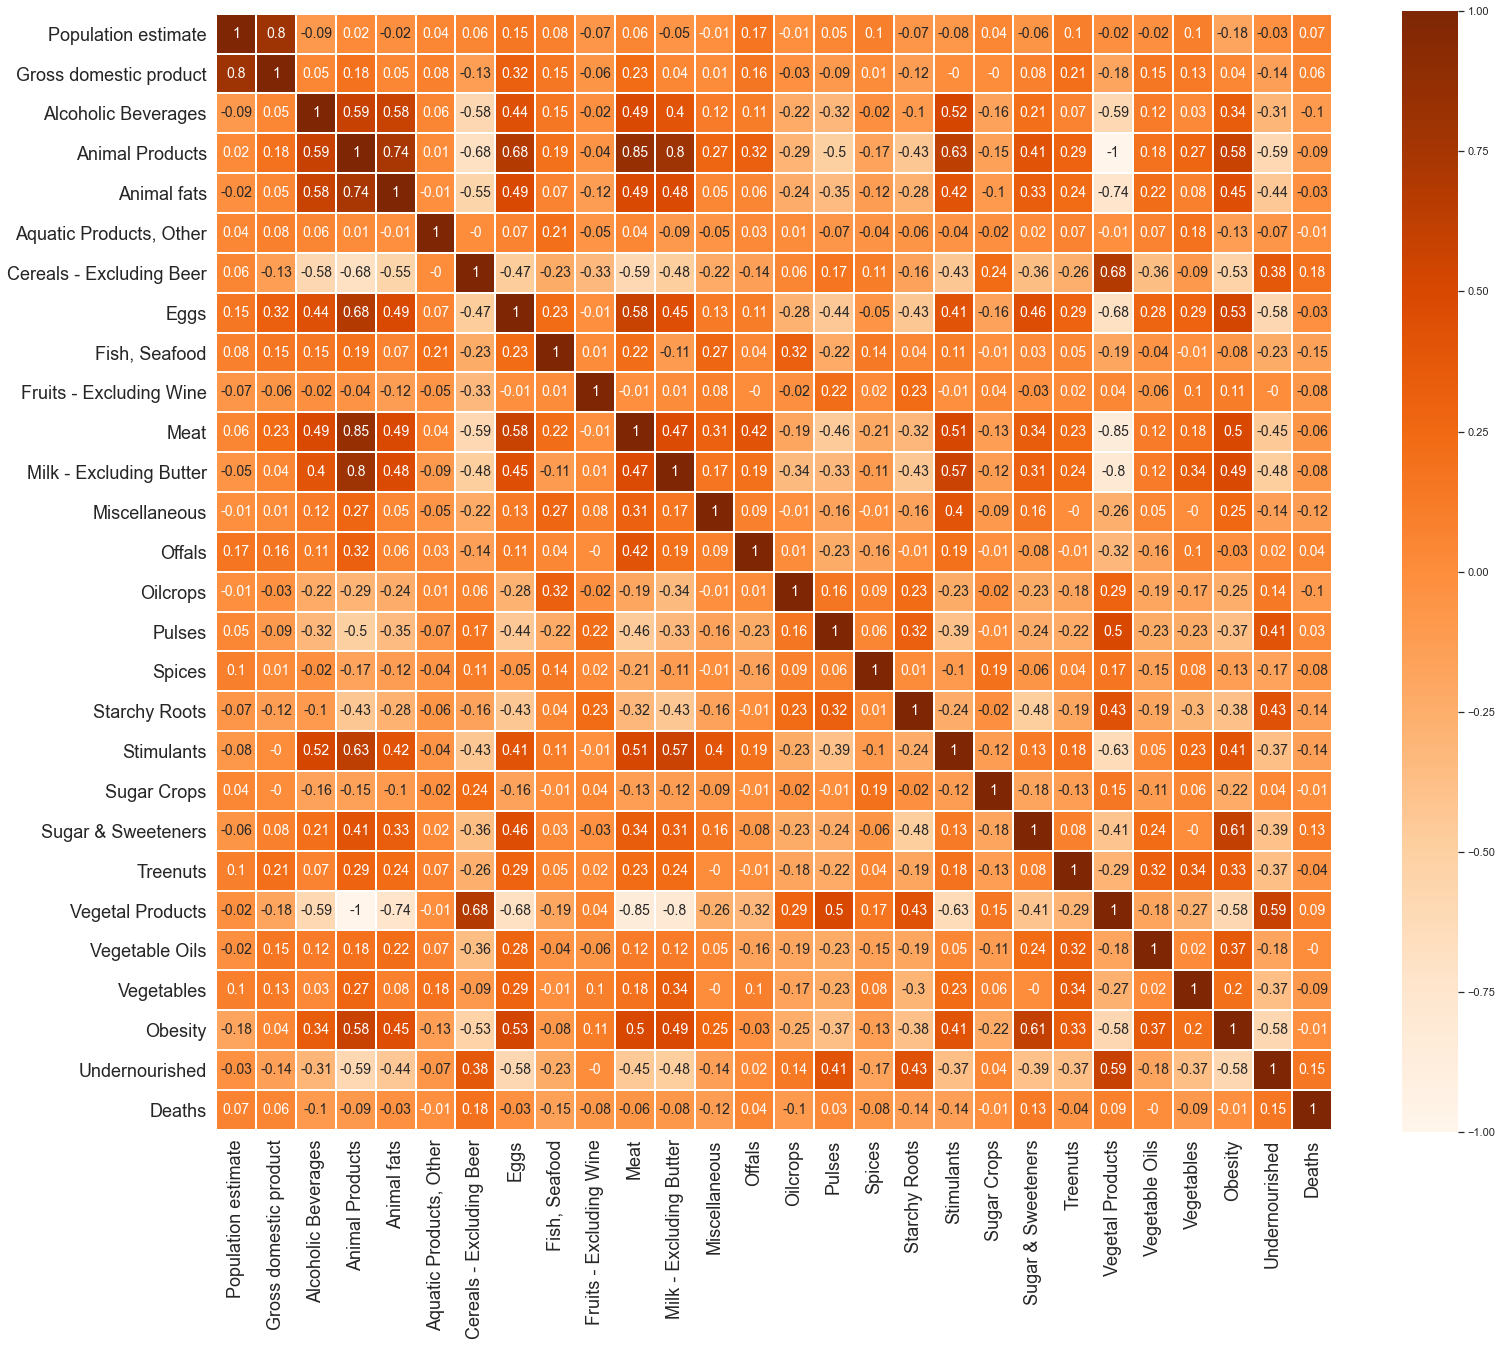

In [261]:
plt.figure(figsize=(25, 25))

sb.heatmap(sub_df.corr().round(2), vmin=-1, vmax=1,
          square=True, cmap="Oranges", linewidths=1, 
           annot=True, annot_kws={"size": 14}, cbar_kws={"shrink": 0.825})

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

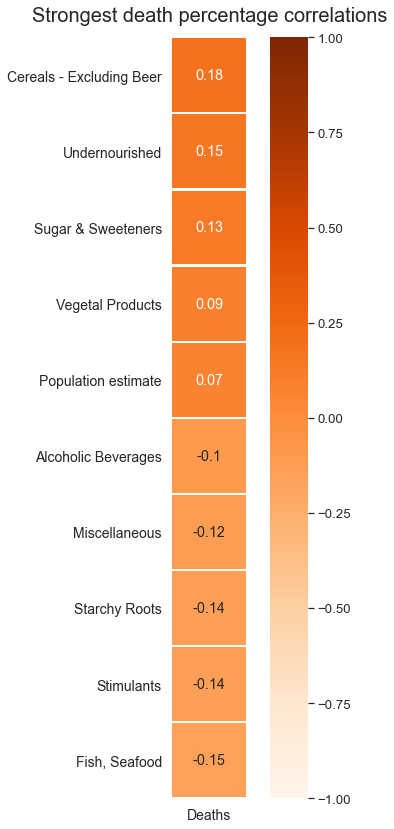

In [262]:
sub_df_corr = sub_df.corr().round(2)
deaths_corr = pd.DataFrame(sub_df_corr[abs(sub_df_corr["Deaths"]) > 0.05].drop(index="Deaths")["Deaths"].sort_values(ascending=False))
deaths_corr.rename({"Deaths": "Deaths correlation"}, inplace=True)

plt.figure(figsize=(8, 14))
sb.set(font_scale=1.2)

sb.heatmap(pd.concat([deaths_corr.head(5), deaths_corr.tail(5)]), vmin=-1, vmax=1,
          square=True, cmap="Oranges", annot=True, linewidths=1.2)

plt.title("Strongest death percentage correlations", fontsize=20, pad=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

<h3>Continent based</h3>

In [263]:
grouped_by_continents.rename(columns={"gdp_md_est": "Gross domestic product",
                       "pop_est": "Population estimate"}, inplace=True)
grouped_by_continents = grouped_by_continents.astype(float).round(3)

In [264]:
# Note: Correlation != Causation !!
    # Possible explanation for features such as obesity, stimulants etc. anti-correlated with deaths:
    # very likely to be correlated with a developed country -> less deaths

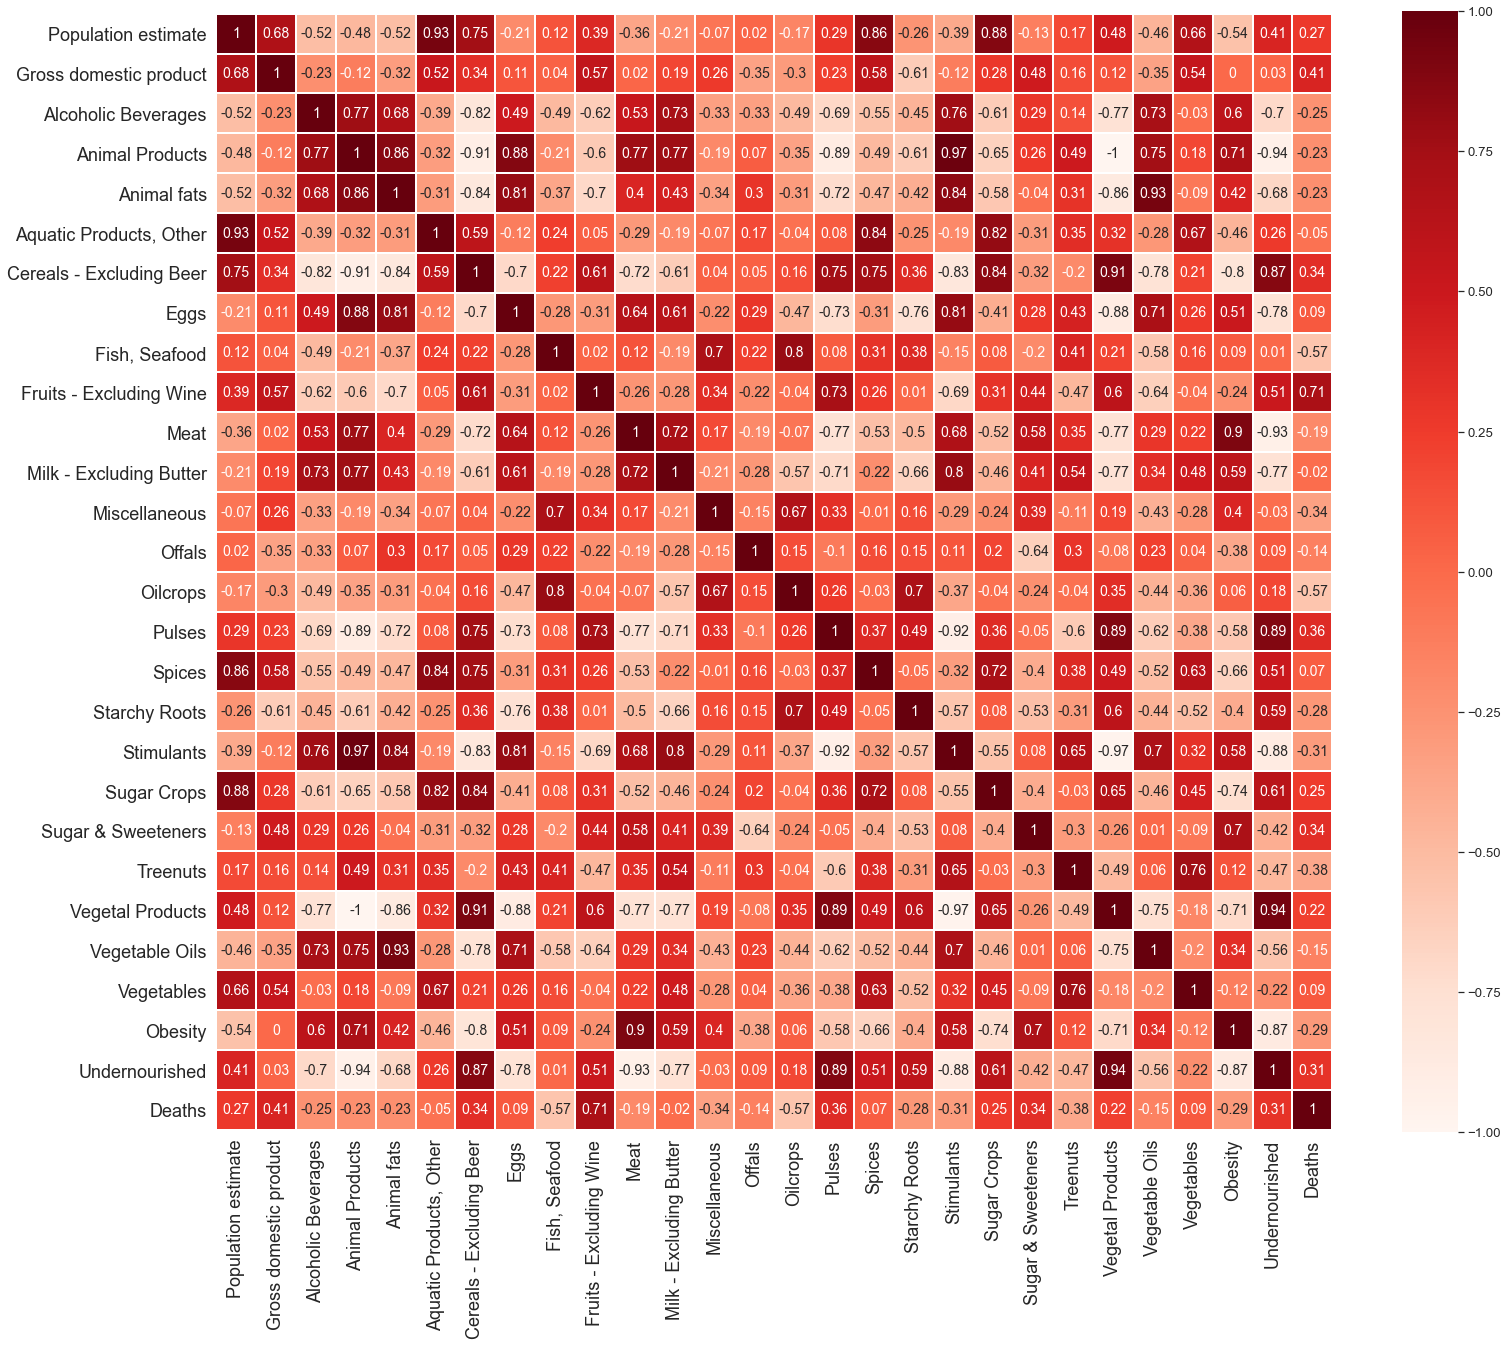

In [265]:
plt.figure(figsize=(25, 25))

sb.heatmap(grouped_by_continents.corr().round(2), vmin=-1, vmax=1,
          square=True, cmap="Reds", linewidths=1, 
           annot=True, annot_kws={"size": 14}, cbar_kws={"shrink": 0.825})

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

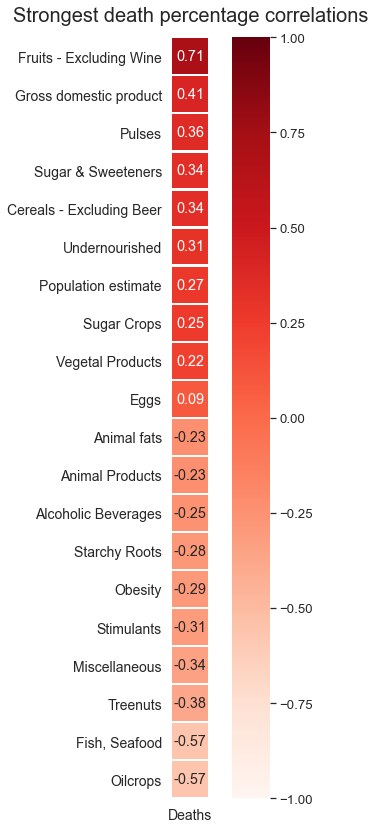

In [266]:
grouped_by_continents_corr = grouped_by_continents.corr().round(2)
deaths_corr = pd.DataFrame(grouped_by_continents_corr[abs(grouped_by_continents_corr["Deaths"]) > 0.05].drop(index="Deaths")["Deaths"].sort_values(ascending=False))
deaths_corr.rename({"Deaths": "Deaths correlation"}, inplace=True)

plt.figure(figsize=(8, 14))
sb.set(font_scale=1.2)

sb.heatmap(pd.concat([deaths_corr.head(10), deaths_corr.tail(10)]), vmin=-1, vmax=1,
          square=True, cmap="Reds", annot=True, linewidths=1.2)

plt.title("Strongest death percentage correlations", fontsize=20, pad=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

<h2>Possible next steps</h2>

    • Transform the variables, find our impactful features and try to re-build some ML models
    • Obtain additional information about the countries, such as health care quality etc.
    • Consult the features with a nutrition specialist and work together towards a relevant research